<span style="font-size: 22px; color: orange;">Predicting an ‘exciting’ Formula 1 race using machine learning models.</span>


This project utilises datasets regarding all Formula 1 races from 1950-2023. Brief in-code annotations are preceeded by a hashtag, whilst markdown cells contain more in-depth explanations and justifications. 

Dataset sources: 

Vopani (2023) 'Formula 1 World Championship (1950-2023)' via Kaggle. Downloaded datasets include 'circuits', 'drivers', 'lap_times', 'pit_stops', 'races', 'results', 'status'
https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

MitchellGleason (2022) 'F1 data analysis: Wet races' via Github. Downloaded dataset was 'weather_descriptions'
https://github.com/MitchellGleason/F1-Data-Analysis--Wet-Races

Race Fans (2023) 'Rate the race: RaceFans' top 100 races' used to create 'top100'
https://www.racefans.net/rate-the-race/f1-fanatic-top-100/

Additional imputed data was manually sourced from Formula1.com, F1-fansite.com and racefans.net where information gaps existed (namely for lap data) directly into the original downloaded CSV files.
https://www.formula1.com
https://www.f1-fansite.com/f1-circuits/albert-park-circuit/
https://www.racefans.net

Further credit extended to Christian Olsson (Kaggle) who undertook a similar project 'Formula 1: What makes a good race?'. Sections of code have been taken from his project with full credit given in the relevant sections.
https://www.kaggle.com/code/christianolsson/formula-1-what-makes-a-good-race/notebook

<span style="font-size: 22px; color: orange;">1. Data wrangling</span>

In [89]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error

In [90]:
# Loading in all datasets
top100=pd.read_csv('/Users/hannah/Desktop/Python/archive/top100.csv')
races=pd.read_csv('/Users/hannah/Desktop/Python/archive/races.csv')
circuits = pd.read_csv('/Users/hannah/Desktop/Python/archive/circuits.csv')
drivers = pd.read_csv('/Users/hannah/Desktop/Python/archive/drivers.csv')
lap_times = pd.read_csv('/Users/hannah/Desktop/Python/archive/lap_times.csv')
pit_stops = pd.read_csv('/Users/hannah/Desktop/Python/archive/pit_stops.csv')
results = pd.read_csv('/Users/hannah/Desktop/Python/archive/results.csv')
status = pd.read_csv('/Users/hannah/Desktop/Python/archive/status.csv')
url = "https://raw.githubusercontent.com/MitchellGleason/F1-Data-Analysis--Wet-Races/main/Exported%20Dataframes/weather_description.csv"
weather = pd.read_csv(url)

In [91]:
# Doing some initial dataset cleaning as I'm interesting in studying races from 2008-present day
# Datasets contain data from 1950 onwards so these must be removed
# Unnecessary columns are also being removed here
races = races[races['year'] >= 2008]
races = races.drop(columns=['round', 'date', 'time' ,'url'])
results = results.drop(columns=['constructorId', 'positionText', 'positionOrder', 'points', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed'])
results = pd.merge(results, races[['raceId', 'year']], on='raceId', how='inner')
circuits = circuits.drop(columns=['location', 'lat', 'lng', 'alt', 'url'])
drivers = drivers.drop(columns=['number', 'code', 'forename', 'surname', 'dob', 'url'])

At this point, I could create a singular dataset merging the individual ones together. However, in this analysis I've decided to keep them separate for now just to make it easier to work with the data they contain as some store data per lap, others per race etc. This makes the running of functions easier + faster

In [92]:
# Since I made the top 100 races dataset, I want to merge it with the races dataset by 'raceID' (for compatability purposes)
merged_df = pd.merge(top100, races, on=['name', 'year'], how='left')

# Update 'raceID' column in df1 with the values from merged_df
top100['raceID'] = merged_df['raceId']

# Changing capitalisation of column name for later compatability
top100.rename(columns={'raceID': 'raceId'}, inplace=True)

# Display the updated dataframe
top100

,raceId,name,points,year
0,879,Brazilian Grand Prix,9.45,2012
1,1020,German Grand Prix,9.44,2019
2,843,Chinese Grand Prix,9.24,2011
3,906,Canadian Grand Prix,9.19,2014
4,910,Hungarian Grand Prix,9.14,2014
...,...,...,...,...
95,855,Japanese Grand Prix,7.57,2011
96,975,Canadian Grand Prix,7.55,2017
97,353,Korean Grand Prix,7.54,2010
98,970,Chinese Grand Prix,7.53,2017


In [93]:
# I noticed that when I loaded in my data, there were a couple NA values in the 'raceID' column
# The following code will let me identify them so I can see what the issue is 
rows_with_na = top100[top100.isna().any(axis=1)]
print("Rows with NA values:")
print(rows_with_na)

Rows with NA values:
Empty DataFrame
Columns: [raceId, name, points, year]
Index: []


**NOTE:**
5 rows came up, all of which were flagged based on naming style differences between the website I collected my data from and the races dataset (EG. Website wrote 'South Korean Grand Prix', race dataset had it saved as 'Korean Grand Prix').

Upon inspection in Python, I returned to my Excel csv where I edited these, before loading my data back in 

In [94]:
# Examining the data types of each column
top100.dtypes

raceId      int64
name       object
points    float64
year        int64
dtype: object

**Initial data visualisation:**

First and foremost, I want to see whether there is variation between the scores awarded to different races. I hypothesise that there will be variation in scores across both the years and the different tracks raced on. To address this, I want to generate some basic plots to better understand the data at hand.


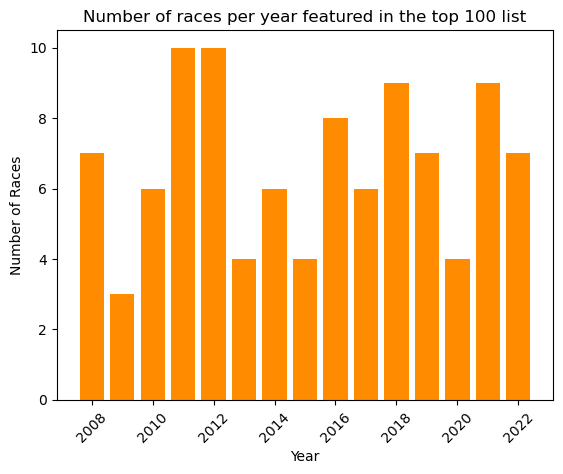

In [95]:
# Plot 1: Number of races in top 100 per year (bar graph)
racecount = top100['year'].value_counts().sort_index()
plt.bar(racecount.index, racecount.values, color='darkorange')
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.title('Number of races per year featured in the top 100 list', fontsize=12)
plt.xticks(rotation=45)
plt.show()

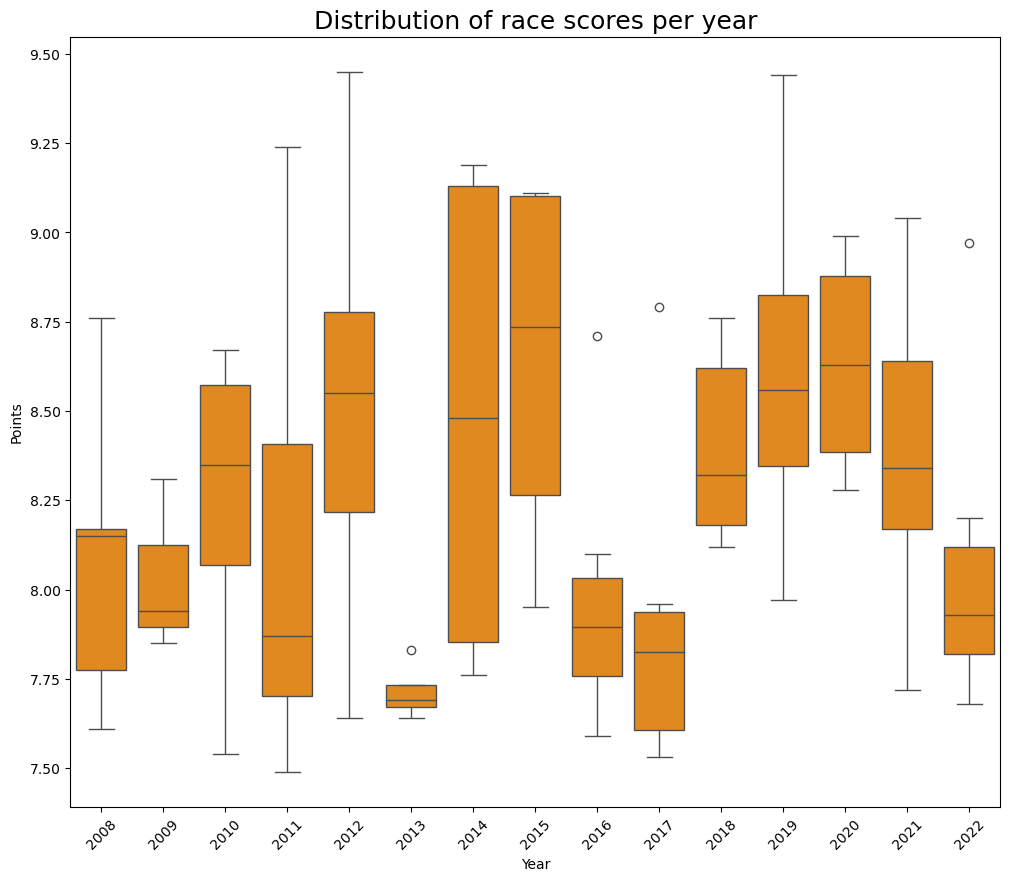

In [8]:
# Plot 2: Distribution of race scores per year (box plot)
plt.figure(figsize=(12,10))
sns.boxplot(x='year', y='points', data=top100, color='darkorange')
plt.xlabel('Year')
plt.ylabel('Points')
plt.title('Distribution of race scores per year', fontsize=18)
plt.xticks(rotation=45)
plt.show()

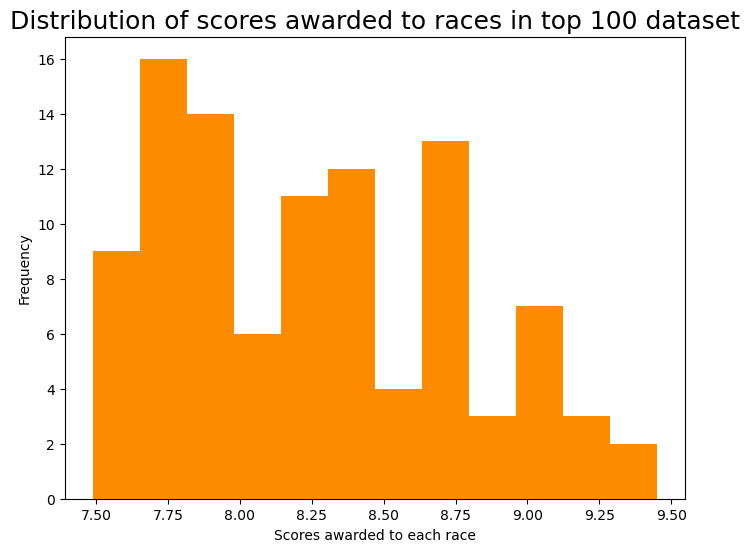

In [9]:
# Plot 3: Distribution of scores in the top 100 dataset (histogram)
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(top100['points'],bins=12,color='darkorange')
plt.xlabel('Scores awarded to each race')
plt.ylabel('Frequency')
plt.title('Distribution of scores awarded to races in top 100 dataset',fontsize=18)
plt.show()

I can also tabulate this information to have an overview of the data at hand, aggregating the data by the number of track appearances, total awarded points and average score. 

In [10]:
# Producing counts
racecounts = top100['name'].value_counts()
racepoints = top100.groupby('name')['points'].sum()
averagescores = racepoints / racecounts
summary = pd.concat([racecounts, racepoints, averagescores], axis=1, keys=['Race Counts', 'Total Race Points', 'Average Score'])
print(summary)

                           Race Counts  Total Race Points  Average Score
name                                                                    
Brazilian Grand Prix                 7              59.61       8.515714
Hungarian Grand Prix                 7              58.62       8.374286
Bahrain Grand Prix                   7              58.19       8.312857
British Grand Prix                   7              58.10       8.300000
Italian Grand Prix                   7              56.61       8.087143
Chinese Grand Prix                   6              50.22       8.370000
Canadian Grand Prix                  6              50.52       8.420000
United States Grand Prix             6              50.17       8.361667
Australian Grand Prix                6              47.31       7.885000
Belgian Grand Prix                   5              39.49       7.898000
Austrian Grand Prix                  5              41.19       8.238000
German Grand Prix                    5             

This answers the first part of my research question - there are clearly differences between the tracks which have affected their relative popularity, resulting in races appearing more/less frequently on the top 100 list. Moreover, some tracks, such as Interlagos (Brazil), Hungaroring (Hungary), Bahrain, Silverstone (British) and Monza (Italian) have received repeatedly high scores. 


Now that I know there's variation across my dataset, I'm interested in understanding the reasons for this. 

Firstly, I need to think about what makes a race more or less exciting. Using a theory-driven approach, I have selected several factors which I believe to have an impact on race scores. These include:
1. Number of did not finishes (DNFs)
2. Number of overtakes 
3. Battles between the top 5 drivers during a race 
4. Lap times 
5. Street circuit versus actual track 
6. Track length 
7. Number of Grand Prixs hosted 
8. Number of turns 
9. Presence of home race driver
10. Weather conditions 
11. Number of pit stops 

**The following section shall outline the data wrangling process.**

**1. Number of DNFs**

Hypothesis: more DNFs = higher race rating

Undoubtedly one of the most exciting features of the sport is the potential for high speed crashes and chaos. Races that stand out in my memory from childhood all include at least one dramatic crash that resulted in a series of drivers retiring their cars or getting pulled from a pile of rubble by marshalls. Therefore, obtaining a count of DNFs per race is certainly essential in an analysis of race excitement.

In these datasets, the 'statusId' column contains a code for each drivers' race outcome, the details of which can be referred to in the status.csv.

In [11]:
# Take for example the 2019 German Grand Prix (raceId 1020), which was awarded a score of 9.44
print(results[results['raceId'] == 1020][['raceId', 'driverId', 'position', 'statusId']])

      raceId  driverId position  statusId
4785    1020       830        1         1
4786    1020        20        2         1
4787    1020       826        3         1
4788    1020       840        4         1
4789    1020       832        5         1
4790    1020       848        6         1
4791    1020       154        7         1
4792    1020       825        8         1
4793    1020         1        9         1
4794    1020         9       10         1
4795    1020       847       11         1
4796    1020         8       12         1
4797    1020       841       13         1
4798    1020       842       14         4
4799    1020       822       \N         3
4800    1020       807       \N         3
4801    1020       844       \N         3
4802    1020       846       \N        75
4803    1020       817       \N        43
4804    1020       815       \N        20


In [12]:
# Here, I can see that 6 cars didn't finish
# Referring back to the status df, I can see the reason for these DNFs using the codes in the statusId column
print(status[status['statusId'].isin([3, 75, 43, 20])])

    statusId      status
2          3    Accident
19        20    Spun off
42        43     Exhaust
74        75  Power loss


Within one race, 6 cars DNF for 4 different reasons, demonstrating the variety of action that can take place within a single race. For this analysis, I'm interested in the number of DNFs that occur during a race to see whether this impacts the race score awarded.

In [96]:
# What I can do is replace all 'NA' values in my 'position' column to 'DNF'
# I can then count the number of DNF values per raceId and create a new column storing this number
results['position'].replace(r'\N', 'DNF', inplace=True)
results['DNF total'] = results.groupby('raceId')['position'].transform(lambda x: x.eq('DNF').sum())

In [97]:
# Now that I've got a new column that contains the number of DNFs per individual raceId, I can create a new dataframe
# In this new dataframe I will store the data for each race & will add to this with each new variable I obtain
# This shall later be joined with my top100 dataset
allvariables = results[['raceId', 'DNF total']].copy()
print(allvariables)

      raceId  DNF total
0         18         14
1         18         14
2         18         14
3         18         14
4         18         14
...      ...        ...
5840    1076          3
5841    1076          3
5842    1076          3
5843    1076          3
5844    1076          3

[5845 rows x 2 columns]


In [98]:
# I see that this has included the duplicates (deriving from results having multiple raceId entries)
# These need to be dropped
allvariables = allvariables.drop_duplicates(subset='raceId', keep='first')
print(allvariables)

      raceId  DNF total
0         18         14
22        19          5
44        20          3
66        21          9
88        22          3
...      ...        ...
5745    1072          5
5765    1073          5
5785    1074          1
5805    1075          6
5825    1076          3

[275 rows x 2 columns]


In [99]:
# I can now also add these to a new column in my top100 dataset using the mutually shared 'raceId' column
merged_df = top100.merge(results[['raceId', 'DNF total']].drop_duplicates(), on='raceId', how='left')
top100 = merged_df

When I ran this, I noticed that there was an issue merging the datasets together despite the shared column. 

In [100]:
# Looking for any rows containing missing data
missing_rows = top100[top100['DNF total'].isna()]
print("Rows with missing values in 'DNF total' column:")
print(missing_rows[['raceId', 'name', 'DNF total']])

Rows with missing values in 'DNF total' column:
    raceId                      name  DNF total
11    1083        British Grand Prix        NaN
47    1095      Brazilian Grand Prix        NaN
58    1093  United States Grand Prix        NaN
76    1084       Austrian Grand Prix        NaN
88    1086      Hungarian Grand Prix        NaN


Here, I realised that my additional datasets (races, results etc.) were only updated for half of the 2022 season. Unfortunately, that means I must drop some of these races from my study as I do not have data for them. This remains a limitation of my project as filling these blanks lies beyond the bounds of my project scope.

In [101]:
# Dropping the rows for which I don't have DNF data for
top100 = top100.dropna(subset=['DNF total'])

In [102]:
# Convert the 'DNF_total' column to int64
top100['DNF total'] = top100['DNF total'].astype('int64')

**2. Number of overtakes**

Hypothesis: more overtakes = higher race rating

Perhaps the greatest beauty of the sport lies in the skillful ability of drivers to overtake one another in narrow corners and along vast straights at high speed. Races that see more 'action' are typically those in which drivers are constantly overtaking one another, keeping the competition alive right down to the very last couple of laps. Therefore, analysing how the number of overtakes taking place during a race affects race score is imperative. This data is stored within the lap_times.csv.

In [20]:
# Taking again the example of the 2019 German Grand Prix, we can driver #1's lap time during each lap of the race 
driver1laps = lap_times[(lap_times['driverId'] == 1) & (lap_times['raceId'] == 1020)]
print(driver1laps)

        raceId  driverId  lap  position      time  milliseconds
460414    1020         1    1         1  1:40.299        100299
460415    1020         1    2         1  1:34.720         94720
460416    1020         1    3         1  2:01.968        121968
460417    1020         1    4         1  2:27.023        147023
460418    1020         1    5         1  1:33.431         93431
...        ...       ...  ...       ...       ...           ...
460473    1020         1   60        14  1:17.485         77485
460474    1020         1   61        13  1:18.538         78538
460475    1020         1   62        11  1:17.678         77678
460476    1020         1   63        11  1:17.866         77866
460477    1020         1   64        11  1:19.366         79366

[64 rows x 6 columns]


In [21]:
# We can see who driver #1 was in race 1020 by referring to the drivers.csv
print(drivers[drivers['driverId'].isin([1])])

   driverId driverRef nationality
0         1  hamilton     British


Here, we can see Lewis Hamilton's lap times for every lap of the 2019 German Grand Prix. Despite starting first, at lap 48 something happened to jeopardise his win; landing him 11th place at the race conclusion. 


Using the data stored in this csv file, we are able to plot the performance of drivers throughout a race. 

Text(0, 0.5, 'Position')

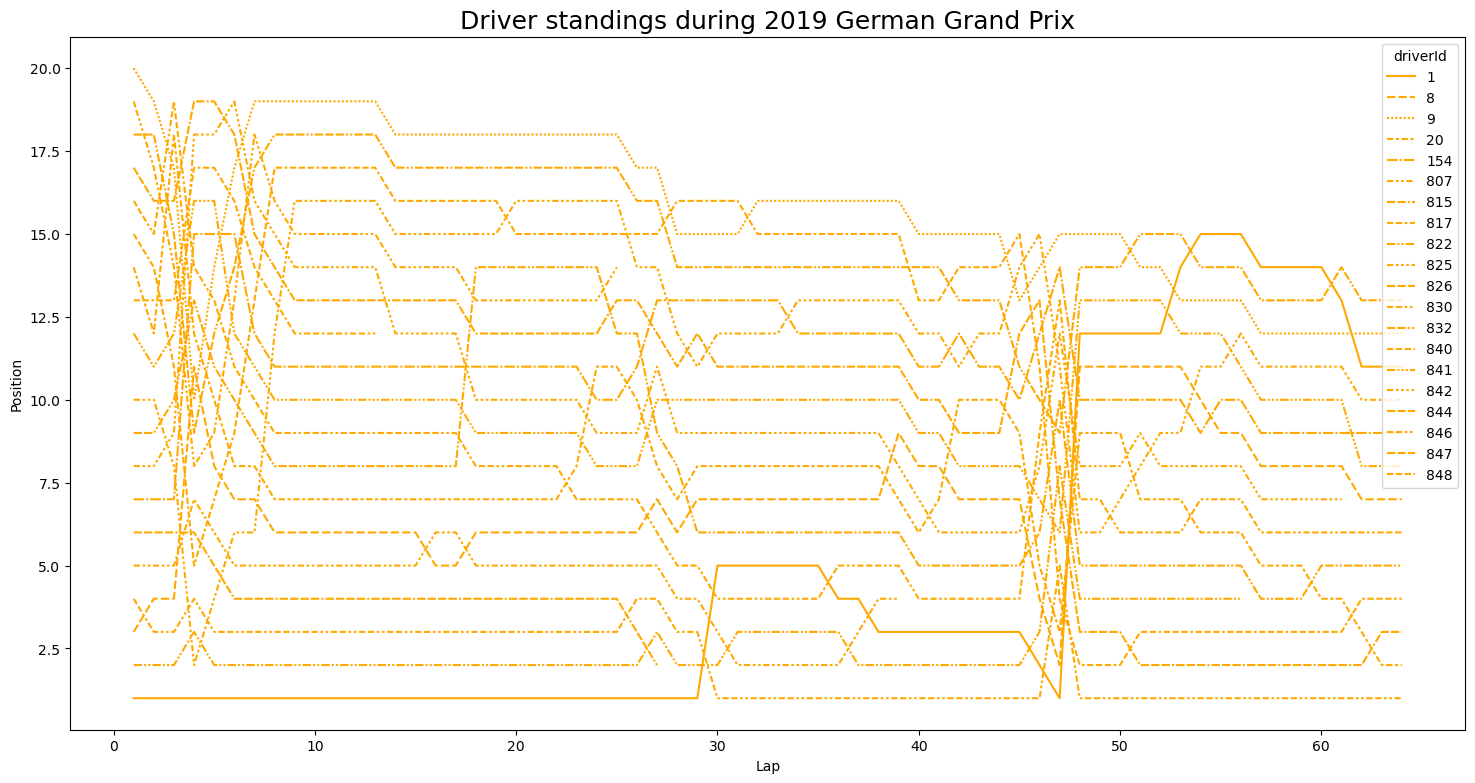

In [26]:
# Plotting the driver standings throughout the 2019 German Grand Prix
germany2019 = lap_times[(lap_times['raceId'] == 1020) | (lap_times['raceId'] == 1020)]
fig, ax = plt.subplots(figsize=(18, 9))
sns.lineplot(x='lap', y='position', style='driverId', data=germany2019, color='#FFA900', ax=ax)
plt.title('Driver standings during 2019 German Grand Prix', fontsize=18)
plt.xlabel('Lap')
plt.ylabel('Position')

This plot clearly points to the race action around lap 48 which caused Lewis to lose his lead. 

For this analysis, I want to obtain a count of these overtakes per race. We can do this by using the 'times' column in the dataset which stores the recorded time taken per lap (per driver) against the data stored in the 'position' column. 

The idea for this was taken from Christian's Kaggle notebook https://www.kaggle.com/code/christianolsson/formula-1-what-makes-a-good-race

Explaining his code, he writes 'when one driver changes his or her position between two adjacent laps, then an overtaking has occurred. Counting the number of occurences this way, and then divide by 2 will give us the number of overtakings since 1 overtaking includes one driver advancing one position, while the other loses one.'

Full credit for this function is attributed to Christian.

In [27]:
# Defining the function
def count_overtakings(laptimes, raceid):
    competing_drivers = []
    for driver in laptimes[laptimes.raceId == raceid].driverId:
        if driver not in competing_drivers:
            competing_drivers.append(driver)

    previous_position = 0
    overtakings = 0
    for driver in competing_drivers:
        for lapPosition in laptimes[(laptimes.raceId == raceid) & (laptimes.driverId == driver)].position:
            if lapPosition != previous_position:
                previous_position = lapPosition
                overtakings += 1

    return int(overtakings/2)

In [34]:
lap_times['overtakings'] = lap_times.raceId.apply(lambda x: count_overtakings(lap_times, x))

Unfortunately, due to the difference in size between my study and Christians, this code takes an incredibly long time to run. Whilst it takes >1 minute to output overtakings for a singular race, it takes at least more than 24 hours to run for the 400+ races in this study (code was left running all day/over night but still did not manage to pass through the whole dataset). For this reason, I will not be including this variable in my modelling, but I wanted to keep this code here for documentation and evidence of my workflow. Ideally, I would get around this computational limit by splitting my dataset into sections, having it run on several machines before merging it back together and removing duplicate values, but unfortunately this lies beyond the scope of my project.

In [ ]:
# I would have now added this column to my variables dataframe
allvariables = lap_times[['raceId', 'overtakings']].copy()

In [ ]:
# I would have also now added these to a new column in my top100 dataset
merged_df = top100.merge(lap_times[['raceId', 'overtakes']].drop_duplicates(), on='raceId', how='left')
top100 = merged_df

**3. Battles between top 5 drivers during a race**

Hypothesis: more variance in top 5 position = higher race rating

The tightest competition is usually felt between the top 5 drivers in a race, all of whom are vying for P1 and the 25 winning points. It is between these drivers that the highest quality racing is typically seen and the greatest tension is felt, particularly as the season progresses. Therefore, it would be valuable to see how variation between these positions during a race affects the race score. 

The following section of code is also taken from Christian's work. In justifying the inclusion of this metric in his work, he writes 'focus in a race is usually on the drivers in the top, so a measurement of how their "battle" is taking shape throughout the race could be interesting to measure. We will approach this by looking at the variance in positions for the drivers who end up in top 5'

Full credit for this function is attributed to Christian.

In [1]:
# Defining the function 
def get_top_5_battle(raceid, results, lap_times):
    f_top_5 = results[(results.raceId == raceid) & (pd.to_numeric(results.position, errors='coerce') < 6)].sort_values(['position'], ascending=True)
    f_top_5_var = []

    for f_driver in f_top_5.driverId:
        f_t5_var = np.var(lap_times[(lap_times.driverId == f_driver) & (lap_times.raceId == raceid)].position)
        f_top_5_var.append(f_t5_var)

    f_top5score = 0
    for f_itervar in f_top_5_var:
        f_top5score = f_top5score + f_itervar

    return f_top5score

In [2]:
# Using the function
results['top5_battle'] = results.raceId.apply(lambda x: get_top_5_battle(x, results, lap_times))

NameError: name 'results' is not defined

Much like my overtakings code before, this too takes a very long time to run on my dataset. For the same reason as above, I shall therefore not be using it as a variable in my final study despite its potential significance on race excitement. This remains a limitation of my study which shall be discussed in my written report.

In [ ]:
# I would now add this column to my variables dataframe
allvariables = results[['raceId', 'top5_battle']].copy()

In [ ]:
# I would also now add these to a new column in my top100 dataset
merged_df = top100.merge(results[['raceId', 'top5_battle']].drop_duplicates(), on='raceId', how='left')
top100 = merged_df

**4. Lap times**

Hypothesis: quicker lap times = higher race rating

At the end of the day, Formula 1 is a game of speed; a fact so well understood that the FIA (governing body) allocate an additional awarded point to the driver responsible for the fastest lap of the race. By design, some race track layouts allow faster average lap times than others which results in more race action and carefully considered strategies seeking to offset tyre degradation. Therefore, calculating the average lap times for drivers per race will be an interesting variable to include when analysing race excitement. 

In [103]:
# Just to check whether the average lap time does vary for the same track across different years, we can examine the case of the German Grand Prix
# Need to get the raceIds of German GPs
germanGP = races[races['name'] == 'German Grand Prix']
germanGPId = germanGP['raceId'].tolist()

# I want to relate these back to the years that each race took place for plotting to come
germanGPyears = races[races['raceId'].isin(germanGPId)][['raceId', 'year']]
germanGPyears = germanGPyears.sort_values(by='year')

In [104]:
# I want to calculate the average time taken per lap for each race by averaging across each time stored in lap_times
# First I need to see how my data is stored in lap_times
lap_times.dtypes

raceId           int64
driverId         int64
lap              int64
position         int64
time            object
milliseconds     int64
dtype: object

In [105]:
# Given that milliseconds is already an int64, I will use it for this analysis
lap_times['milliseconds'] = pd.to_numeric(lap_times['milliseconds'])
lap_times['average lap time'] = lap_times.groupby('raceId')['milliseconds'].transform('mean')

This has created a column storing the 'average lap time' for each unique raceId, stored within the lap_times.csv.

In [106]:
# Now if I want to see how the average lap time varies for all the German Grand Prix data I have:
germanGPIds = [9, 27, 64, 82, 101, 119, 135, 152, 168, 184, 201, 216, 234, 248, 265, 282, 298, 313, 329, 347, 364, 380, 395, 413, 428, 446, 461, 478, 492, 506, 521, 537, 553, 569, 586, 600, 615, 627, 638, 650, 662, 674, 685, 695, 705, 714, 724, 734, 743, 761, 772, 781, 790, 804, 814, 822, 830, 850, 869, 888, 909, 959, 999, 1020]
germanLapAverage = lap_times[lap_times['raceId'].isin(germanGPIds)]
GermanAverageByRace = germanLapAverage.groupby('raceId')['average lap time'].mean()
print(GermanAverageByRace)

raceId
9        97746.690539
27       82439.620744
64       79954.094582
82       79924.069020
101      77843.470882
119      82703.951081
135      80844.477745
152     106369.786585
168     114235.457908
184     110625.740280
201     109460.432143
216     109984.960305
234     111430.562682
347      80806.173661
850     100239.721917
869      83038.703797
888     102192.115059
909      85535.870992
959      82800.560734
999      83211.080000
1020     98449.841556
Name: average lap time, dtype: float64


In [107]:
# I can now plot this on a bar chart to visualise the variation in average lap time for each German Grand Prix
# First I need to merge the lap_times dataframe with my german GP years list 
merged_df = pd.merge(germanGPyears, lap_times, on='raceId')

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(merged_df['year'], merged_df['average lap time'], color='darkorange')
plt.title('Average Lap Time for German Grand Prix by Year')
plt.xlabel('Year')
plt.ylabel('Average Lap Time')
plt.xticks(range(2008, 2021), rotation=45, ha='right')
plt.show()

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x14c98b240>
Traceback (most recent call last):
  File "/Users/hannah/anaconda3/envs/envGEOG0115/lib/python3.11/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))

KeyboardInterrupt: 


KeyboardInterrupt: 

This bar chart confirms what was expected: that the average lap time varies across identical tracks each year. Therefore, this variable shall be used in analysis to follow.

In [108]:
# I can now add this column to my variables dataframe
allvariables = pd.merge(allvariables, lap_times[['raceId', 'average lap time']].drop_duplicates(), on='raceId', how='left')

In [109]:
# I can now add this new column 'average lap time' to my top100 dataset
merged_df = top100.merge(lap_times[['raceId', 'average lap time']].drop_duplicates(), on='raceId', how='left')
top100 = merged_df

**5. Circuit type**

Hypothesis: race circuits = higher race rating (than street circuits)

Lots of discussion is had about whether a street circuit, or a traditional race track leads to a more interesting race. More often than not, traditional tracks create better conditions for competitive racing, whilst street circuits produce excellent spectator fanfare. As a result, it would be interesting to consider whether this has an impact on race scores. None of the datasets currently list whether or not a track is a race or street circuit - therefore this information must be added manually to the circuit.csv using the circuitRef column after making two lists categorising each track type. Track type information was obtained via the Wikipedia urls listed in the url column.

In [111]:
street = 'albert_park', 'monaco', 'villeneuve', 'valencia', 'marina_bay', 'adelaide', 'phoenix', 'detroit', 'dallas', 'long_beach', 'las_vegas', 'montjuic', 'lemans', 'reims', 'zeltweg', 'aintree', 'boavista', 'riverside', 'avus', 'ain-diab', 'pescara', 'pedralbes', 'port_imperial', 'BAK', 'hanoi', 'jeddah', 'miami'

race = 'sepang', 'bahrain', 'catalunya', 'istanbul', 'magny_cours', 'silverstone', 'hockenheimring', 'hungaroring', 'spa', 'monza', 'fuji', 'shanghai', 'interlagos', 'indianapolis', 'nurburgring', 'imola', 'suzuka', 'osterreichring', 'yas_marina', 'galvez', 'jerez', 'estoril', 'okayama', 'kyalami', 'donington', 'rodriguez', 'ricard', 'yeongam', 'jacarepagua', 'brands_hatch', 'zandvoort', 'zolder', 'dijon', 'jarama', 'watkins_glen', 'anderstorp', 'mosport', 'nivelles', 'charade', 'tremblant', 'essarts', 'george', 'monsanto', 'sebring', 'bremgarten', 'buddh', 'americas', 'red_bull_ring', 'sochi', 'portimao', 'mugello', 'losail'

In [112]:
# List of street circuits and race circuits
street = ['albert_park', 'monaco', 'villeneuve', 'valencia', 'marina_bay', 'adelaide', 'phoenix', 'detroit',
          'dallas', 'long_beach', 'las_vegas', 'montjuic', 'lemans', 'reims', 'zeltweg', 'aintree', 'boavista',
          'riverside', 'avus', 'ain-diab', 'pescara', 'pedralbes', 'port_imperial', 'BAK', 'hanoi', 'jeddah',
          'miami']

race = ['sepang', 'bahrain', 'catalunya', 'istanbul', 'magny_cours', 'silverstone', 'hockenheimring',
        'hungaroring', 'spa', 'monza', 'fuji', 'shanghai', 'interlagos', 'indianapolis', 'nurburgring', 'imola',
        'suzuka', 'osterreichring', 'yas_marina', 'galvez', 'jerez', 'estoril', 'okayama', 'kyalami', 'donington',
        'rodriguez', 'ricard', 'yeongam', 'jacarepagua', 'brands_hatch', 'zandvoort', 'zolder', 'dijon', 'jarama',
        'watkins_glen', 'anderstorp', 'mosport', 'nivelles', 'charade', 'tremblant', 'essarts', 'george', 'monsanto',
        'sebring', 'bremgarten', 'buddh', 'americas', 'red_bull_ring', 'sochi', 'portimao', 'mugello', 'losail']

# Function to determine track type
def determine_track_type(row):
    if row['circuitRef'] in street:
        return 'street'
    elif row['circuitRef'] in race:
        return 'race'
    else:
        return 'unknown'

# Create a new column in 'circuits' called 'trackType' using function defined above
circuits['track type'] = circuits.apply(determine_track_type, axis=1)

# Inspect
circuits

,circuitId,circuitRef,laps,corners,name,country,nationality,track type
0,1,albert_park,58,16,Albert Park Grand Prix Circuit,Australia,Australian,street
1,2,sepang,56,15,Sepang International Circuit,Malaysia,Malaysian,race
2,3,bahrain,57,15,Bahrain International Circuit,Bahrain,Bahraini,race
3,4,catalunya,66,16,Circuit de Barcelona-Catalunya,Spain,Spanish,race
4,5,istanbul,58,14,Istanbul Park,Turkey,Turkish,race
...,...,...,...,...,...,...,...,...
74,75,portimao,66,15,Autódromo Internacional do Algarve,Portugal,Portuguese,race
75,76,mugello,59,15,Autodromo Internazionale del Mugello,Italy,Italian,race
76,77,jeddah,50,27,Jeddah Corniche Circuit,Saudi Arabia,Saudi,street
77,78,losail,57,16,Losail International Circuit,Qatar,Qatari,race


In [113]:
# Now I want to merge this with my allvariables and top100 dataset
# To do this however, I must first merge it with my 'races' dataset as 'circuits' does not have a raceId column, using instead a 'circuitId' column 
merged_df = races.merge(circuits[['circuitId', 'track type']], on='circuitId', how='left')
races = merged_df

In [114]:
# I can now add this column to my variables dataframe
allvariables = pd.merge(allvariables, races[['raceId', 'track type']], on='raceId', how='left')

In [115]:
# Finally, to merge with top100
merged_df = top100.merge(races[['raceId', 'track type']].drop_duplicates(), on='raceId', how='left')
top100 = merged_df

**6. Track length**

Hypothesis: more laps = higher race rating

Some tracks that are frequently criticised by fans tend to be characterised by fewer laps and longer straights. Whilst this has benefits for the management of events (greater area to seat more fans), this can in some cases lead to a less engaging race as racing positions stabilise earlier in the race, causing pole sitters to dominate early on. Therefore, it would be interesting to see whether this opinion translates in the race scores. This shall be measured not by distance, but by the number of laps in each race. 

This data was not included in the original circuits.csv. Therefore, data had to be manually imputed in Excel using data derived from the linked Wikipedia pages for each track. This was easier to do than creating a similar function to variable #5 above as lap numbers cannot be categorised so simply.

In [37]:
# Examining the number of laps for each track
numberOfLaps = circuits[['circuitId', 'laps']]
print(numberOfLaps)

    circuitId  laps
0           1    58
1           2    56
2           3    57
3           4    66
4           5    58
..        ...   ...
74         75    66
75         76    59
76         77    50
77         78    57
78         79    57

[79 rows x 2 columns]


In [38]:
# We can examine the details of individual tracks, such as the German Grand Prix (circuitId 10)
print(circuits[circuits['circuitId'].isin([10])])

   circuitId      circuitRef  laps  corners            name  country  \
9         10  hockenheimring    49       17  Hockenheimring  Germany   

  nationality track type  
9      German       race  


In [116]:
# Like with circuit type, I want to add this column to my races dataframe, before adding it to my top100 dfs
merged_df = races.merge(circuits[['circuitId', 'laps']], on='circuitId', how='left')
races = merged_df

In [117]:
# I can now add this column to my variables dataframe
allvariables = pd.merge(allvariables, races[['raceId', 'laps']], on='raceId', how='left')

In [118]:
# I can join this with my top100 dataset
merged_df = top100.merge(races[['raceId', 'laps']], on='raceId', how='left')
top100 = merged_df

In [42]:
# Now my dataset contains a count of the number of laps for each track
top100

,raceId,name,points,year,DNF total,average lap time_x,average lap time_y,track type,laps
0,879,Brazilian Grand Prix,9.45,2012,5,89864.105376,89864.105376,race,71
1,1020,German Grand Prix,9.44,2019,6,98449.841556,98449.841556,race,49
2,843,Chinese Grand Prix,9.24,2011,1,105659.250779,105659.250779,race,56
3,906,Canadian Grand Prix,9.19,2014,8,86272.669506,86272.669506,street,70
4,910,Hungarian Grand Prix,9.14,2014,6,98855.572594,98855.572594,race,70
...,...,...,...,...,...,...,...,...,...
90,855,Japanese Grand Prix,7.57,2011,1,104489.398034,104489.398034,race,53
91,975,Canadian Grand Prix,7.55,2017,4,81126.521331,81126.521331,street,70
92,353,Korean Grand Prix,7.54,2010,9,198826.324521,198826.324521,race,55
93,970,Chinese Grand Prix,7.53,2017,5,107367.675526,107367.675526,race,56


**7. Number of Grand Prix races hosted**

Hypothesis: greater number of Grand Prix races hosted = higher race rating

Although 79 individual circuits are listed within the circuit.csv file, not all of these have been raced equally. In fact, several tracks have never been raced at all; canned at the very last minute due to organisational or financial issues. Contrastingly, several tracks have proved to be a great success amongst drivers, teams, organisers and fans alike, leading to their repeated inclusion in championship calendars. It would be interesting therefore to consider whether a correlation exists between the rating of a race and the number of times its track has been driven.

In [43]:
# I can easily count how many races have been held at each circuit using their individual circuitId codes
# I shall examine this first by using the German Grand Prix as the example
circuitCountGermany = races[races['circuitId'] == 10]
howManyAtGermany = len(circuitCountGermany)
print(f"Number of races held in Germany: {howManyAtGermany}")

Number of races held in Germany: 7


In [119]:
# I can create a new column which stores this count for each circuitId
races['races hosted'] = races.groupby('circuitId')['raceId'].transform('count')
print(races)

     raceId  year  circuitId                      name track type  laps  \
0         1  2009          1     Australian Grand Prix     street    58   
1         2  2009          2      Malaysian Grand Prix       race    56   
2         3  2009         17        Chinese Grand Prix       race    56   
3         4  2009          3        Bahrain Grand Prix       race    57   
4         5  2009          4        Spanish Grand Prix       race    66   
..      ...   ...        ...                       ...        ...   ...   
289    1092  2022         22       Japanese Grand Prix       race    53   
290    1093  2022         69  United States Grand Prix       race    56   
291    1094  2022         32    Mexico City Grand Prix       race    71   
292    1095  2022         18      Brazilian Grand Prix       race    71   
293    1096  2022         24      Abu Dhabi Grand Prix       race    58   

     races hosted  
0              13  
1              10  
2              12  
3              15  

In [120]:
# I can now add this column to my variables dataframe
allvariables = pd.merge(allvariables, races[['raceId', 'races hosted']], on='raceId', how='left')

In [121]:
# I can add this as another column in my top100 dataframe using the same method as before
merged_df = top100.merge(races[['raceId', 'races hosted']], on='raceId', how='left')
top100 = merged_df

**8. Number of turns**

Hypothesis: greater number of turns = higher race rating

Another factor that influences the excitement of a Formula 1 race is the number of corners a track has. It is widely understood that the more corners a track has, the greater the opportunities for overtakes and diverse strategies to be employed. Therefore, this study shall consider how the number of corners affects the race score.

The circuits.csv originally did not have a corners column, so this data was manually imputed using the Wikipedia url references included in the file to obtain records for each track. These were added in Excel before loading the file back into Python.

In [122]:
# As with the circuit type, this information must be added to results csv as well as top100
merged_df = races.merge(circuits[['circuitId', 'corners']], on='circuitId', how='left')
races = merged_df

In [123]:
# I can now add this column to my variables dataframe
allvariables = pd.merge(allvariables, races[['raceId', 'corners']], on='raceId', how='left')

In [124]:
# Now to merge with top100
merged_df = top100.merge(races[['raceId', 'corners']], on='raceId', how='left')
top100 = merged_df

**9. Presence of home driver**

Hypothesis: presence of home driver = higher race rating

As with all sports, the presence of a driver competing at his home race typically has a clear impact on audience support, with crowds cheering for the victory of their home driver. I want to see whether this translates to race scores. 

In the original circuit.csv, the location and country of each circuit is listed. However in the driver.csv, nationality is listed. Therefore, 'nationality' was manually included to the circuit.csv so the two files could be joined together on a mutual column. 

In [125]:
# First, I want to join the 'nationality' column in circuits to races using the circuitID
# This tells me the country that each circuit is located in 
races = pd.merge(races, circuits[['circuitId', 'nationality']], on='circuitId', how='left')

In [126]:
# Now I want to join the driverId columns from the drivers.csv using the newly merged nationality column
# This joins drivers to races at which it was their home race
races = pd.merge(races, drivers[['driverId', 'nationality']], on='nationality', how='left')

In [127]:
# Now I want to create a function that replaces the driverId code with 'present' or fills NA values with 'not present'
# This is because for the purposes of this study, I'm not interested in which driver is present, rather just whether there is one or not
def replaceDriverId(value):
    if pd.notna(value):  
        return 'present'   
    else:
        return 'not present'  

# Applying the function to 'driverId' column
races['driverId'] = races['driverId'].apply(replaceDriverId)

In [128]:
# I want to rename this column to be 'presence of home driver' 
races.rename(columns={'driverId': 'presence of home driver'}, inplace=True)

In [129]:
# I can now add this column to my variables dataframe
allvariables = pd.merge(allvariables, races[['raceId', 'presence of home driver']].drop_duplicates(), on='raceId', how='left')

In [130]:
# Finally I want to merge this with top100
merged_df = top100.merge(races[['raceId', 'presence of home driver']].drop_duplicates(), on='raceId', how='left')
top100 = merged_df

**10. Weather conditions**

Hypothesis: wet weather = higher race rating

Races that experience wet weather conditions are always chaotic as drivers struggle with adverse conditions and battle for tyre stability. Certainly for me, some of my favourite Formula 1 races include those where heavy rain affected the race outcome. As a result, it would be interesting to see how race scores for wet races compare to dry races.

In [56]:
# Github user MitchellGleason uploaded a dataset containing a description of the weather for every F1 race since 1950
weather

,Unnamed: 0,year,name,race_id,weather_description,is_it_wet
0,0,1950,French Grand Prix,838,Hot and sunny,Not Wet
1,1,1950,Belgian Grand Prix,837,"Warm, dry and sunny",Not Wet
2,2,1950,British Grand Prix,833,"Sunny, mild, dry.",Not Wet
3,3,1950,Indianapolis 500,835,Rainy,Wet
4,4,1950,Monaco Grand Prix,834,No weather description,Not Wet
...,...,...,...,...,...,...
1074,1074,2022,Mexico City Grand Prix,1094,Partly cloudy,Not Wet
1075,1075,2022,Monaco Grand Prix,1080,Rain and partly cloudy in wet-and-drying track...,Wet
1076,1076,2022,Abu Dhabi Grand Prix,1096,Clear,Not Wet
1077,1077,2022,Bahrain Grand Prix,1074,Clear,Not Wet


In [131]:
# I'm interested in the 'is_it_wet' column
# For my analysis, I need to join this to my top100 datasets
# First, I want to see how many races since 1950 experienced wet weather conditions
weather['is_it_wet'].value_counts()

is_it_wet
Not Wet    924
Wet        155
Name: count, dtype: int64

In [132]:
# Need to rename the columns for compatability between datasets
weather.rename(columns={'race_id': 'raceId'}, inplace=True)

In [133]:
# I want to rename the column for consistency
weather.rename(columns={'is_it_wet': 'weather'}, inplace=True)

In [134]:
# I can now add this column to my variables dataframe
allvariables = pd.merge(allvariables, weather[['raceId', 'weather']].drop_duplicates(), on='raceId', how='left')

In [135]:
# Merge with top100
merged_df = top100.merge(weather[['raceId', 'weather']].drop_duplicates(), on='raceId', how='left')
top100 = merged_df

**11. Number of pit stops**

Hypothesis: more pit stops = higher race rating

Probably the most important feature of race strategy is the number of pit stops taken, as valuable seconds are lost each time drivers enter the pit lane and pause for a stop. Cars can pit for various reasons; after collisions that damage the car, due to tyre degradation, to change strategy or because of wet weather conditions necessitating the need for wet tyres. Some tracks by nature are more intensive on tyres and thus see a greater number of pit stops taken by drivers each race. It would be interesting to see whether this has an effect on the race score given and hence its inclusion in this analysis.

In [136]:
# Calculating the average number of stops for each race using unique raceId codes
average_stops = pit_stops.groupby('raceId')['stop'].mean().reset_index()
average_stops = average_stops.rename(columns={'stop': 'average stops'})
pit_stops = pd.merge(pit_stops, average_stops, on='raceId', how='left')
print(pit_stops)

      raceId  driverId  stop  lap      time duration  milliseconds  \
0        841       153     1    1  17:05:23   26.898         26898   
1        841        30     1    1  17:05:52   25.021         25021   
2        841        17     1   11  17:20:48   23.426         23426   
3        841         4     1   12  17:22:34   23.251         23251   
4        841        13     1   13  17:24:10   23.842         23842   
...      ...       ...   ...  ...       ...      ...           ...   
8923    1076       849     2   23  15:40:00   17.936         17936   
8924    1076         4     1   39  16:05:24   18.796         18796   
8925    1076       825     1   39  16:05:30   19.111         19111   
8926    1076         4     2   53  16:25:28   18.394         18394   
8927    1076       848     1   57  16:30:33   19.845         19845   

      average stops  
0          1.711111  
1          1.711111  
2          1.711111  
3          1.711111  
4          1.711111  
...             ...  
8923 

In [137]:
# I can now add this column to my variables dataframe
allvariables = pd.merge(allvariables, pit_stops[['raceId', 'average stops']].drop_duplicates(), on='raceId', how='left')

In [138]:
# Merge with top100
merged_df = top100.merge(pit_stops[['raceId', 'average stops']].drop_duplicates(), on='raceId', how='left')
top100 = merged_df

Now I have a dataframe 'top100' that contains only the data for races deemed 'exciting' (ie. obtaining a score of 7.49+ by viewers), and a dataset 'allvariables' that contains the data regarding all races that took place between 2008-2022 (including those in top100)

What I want to do is merge the datasets together using the raceIds, create a new column called 'public opinion' and fill this with 'exciting' for those in the top100 dataframe and 'boring' for all others. 

In [139]:
# I want to separate between raceIds in top100 and allvariables  
raceIdstop100 = set(top100['raceId'])
raceIdsallvariables = set(allvariables['raceId'])

# Identifying the common raceIds, storing these in a new df and then creating a column to store the labels
# NA values (ie. ids not shared by both) are filled with 'boring' label
sharedIds = raceIdstop100.intersection(raceIdsallvariables)
shared = pd.DataFrame({'raceId': list(sharedIds)})
shared['public opinion'] = 'exciting'
raceData = pd.merge(allvariables, shared, on='raceId', how='left')
raceData['public opinion'].fillna('boring', inplace=True)

I also want to add back the 'year' and 'name' columns from my races.csv as these aid interpretation/analysis

In [140]:
raceData = pd.merge(raceData, races[['raceId', 'year', 'name']].drop_duplicates(), on='raceId', how='left')

In [141]:
raceData

,raceId,DNF total,average lap time,track type,laps,races hosted,corners,presence of home driver,weather,average stops,public opinion,year,name
0,18,14,98557.182306,street,58,13,16,present,Not Wet,NaN,exciting,2008,Australian Grand Prix
1,19,5,99586.003925,race,56,10,15,present,Not Wet,NaN,boring,2008,Malaysian Grand Prix
2,20,3,97601.399823,race,57,15,15,not present,Not Wet,NaN,boring,2008,Bahrain Grand Prix
3,21,9,91046.762475,race,66,15,16,present,Not Wet,NaN,boring,2008,Spanish Grand Prix
4,22,3,91201.180279,race,58,6,14,not present,Not Wet,NaN,boring,2008,Turkish Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,1072,5,154924.338882,street,50,2,27,not present,Not Wet,1.829787,boring,2021,Saudi Arabian Grand Prix
271,1073,5,93919.292585,race,58,14,16,not present,Not Wet,1.448276,boring,2021,Abu Dhabi Grand Prix
272,1074,1,103134.859305,race,57,15,15,not present,Not Wet,1.965517,exciting,2022,Bahrain Grand Prix
273,1075,6,102404.996324,street,50,2,27,not present,Not Wet,1.105263,exciting,2022,Saudi Arabian Grand Prix


Now I have my final dataset, raceData, which contains all Formula 1 races from 2008 to 2022 with a label derived from public opinion as to whether or not a race was exciting or boring.

<span style="font-size: 22px; color: orange;">2. Exploratory Data Analysis (EDA)</span>

The goal of this section is to perform initial investigations on my data using summary statistics and graphs to discover patterns, spot anomalies and check assumptions

Returning to my research question, I want to predict whether a Formula 1 race will be exciting or not. In terms of my variables:

My target variable is 'Public Opinion' (either 'exciting' or 'boring')
My explanatory variables are:
1. DNF total
2. Average lap time
3. Track type
4. Laps
5. Races hosted
6. Corners
7. Presence of home driver
8. Weather
9. Average stops

As mentioned previously, unfortunately the number of overtakes per race and battles between top 5 drivers had to be dropped from this study due to computational limits. Therefore, 11 variables has dropped to 9.

In [142]:
# Examining the data
raceData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   raceId                   275 non-null    int64  
 1   DNF total                275 non-null    int64  
 2   average lap time         275 non-null    float64
 3   track type               275 non-null    object 
 4   laps                     275 non-null    int64  
 5   races hosted             275 non-null    int64  
 6   corners                  275 non-null    int64  
 7   presence of home driver  275 non-null    object 
 8   weather                  275 non-null    object 
 9   average stops            220 non-null    float64
 10  public opinion           275 non-null    object 
 11  year                     275 non-null    int64  
 12  name                     275 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 28.1+ KB


Here, I can see that 'average stops' has 55 null values. Visual examination of the dataset suggests that the original 'pit_stops' dataset is incomplete. For this reason, unfortunately average stops per race will be dropped from this analysis. This leaves me with 8 explanatory variables

In [143]:
# Dropping the 'average stops' column as well as 'year' and 'name' as these aren't needed for model building/EDA
raceData = raceData.drop(columns=['average stops', 'year', 'name', 'raceId'])

I can also see my  three feature variables and my target variable in categorical form. However, since they each only contain two categories, I can one-hot encode these into numerical form (binary). This is an important step before I create my Decision Tree models which require numerical inputs.

In [144]:
raceData['presence of home driver'] = raceData['presence of home driver'].map({'present': 1, 'not present': 0})
raceData['track type'] = raceData['track type'].map({'race': 1, 'street': 0})
raceData['weather'] = raceData['weather'].map({'Wet': 1, 'Not Wet': 0})
raceData['public opinion'] = raceData['public opinion'].map({'exciting': 1, 'boring': 0})

Now when I look at my dataset, the binary codes mean:
1. Presence of home driver

    1 = present
    0 = not present
2. Track type

   
    1 = race
    0 = street
3. Weather

   
    1 = wet
    0 = not wet
4. Public opinion


    1 = exciting
    0 = boring

In [145]:
# Generating descriptive statistics of the numerical columns
raceData.describe()

,DNF total,average lap time,track type,laps,races hosted,corners,presence of home driver,weather,public opinion
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,3.727273,100895.264331,0.778182,59.792727,11.647273,16.127273,0.789091,0.138182,0.345455
std,2.243031,20928.942248,0.416227,8.509159,3.960934,2.661256,0.408698,0.345720,0.476383
min,0.000000,63150.259308,0.000000,44.000000,1.000000,10.000000,0.000000,0.000000,0.000000
25%,2.000000,87379.508296,1.000000,53.000000,10.000000,15.000000,1.000000,0.000000,0.000000
50%,3.000000,99650.074038,1.000000,58.000000,13.000000,16.000000,1.000000,0.000000,0.000000
75%,5.000000,108041.812253,1.000000,68.000000,15.000000,18.000000,1.000000,0.000000,1.000000
max,14.000000,225823.950000,1.000000,78.000000,16.000000,27.000000,1.000000,1.000000,1.000000


I want to define my predictor (X1) and target (Y1) columns for further descriptive analysis.

In [146]:
X1cols = ['DNF total', 'average lap time', 'track type', 'laps', 'races hosted', 'corners',
          'presence of home driver', 'weather'] 
Y1cols = ['public opinion'] 

In [147]:
X1 = raceData[X1cols]
Y1 = raceData[Y1cols]

In [148]:
# Examining my target variable
Y1.describe()

,public opinion
count,275.000000
mean,0.345455
std,0.476383
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


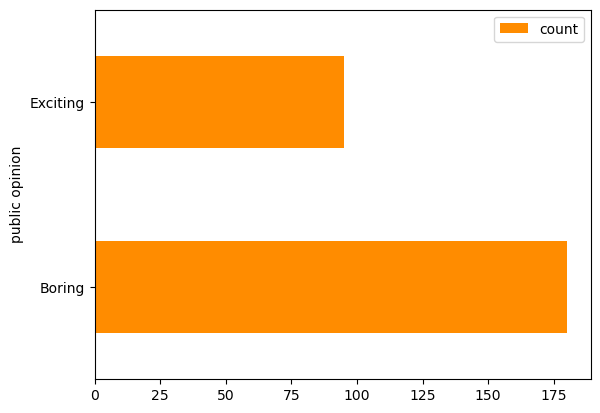

In [149]:
# Plotting this
pd.DataFrame(raceData['public opinion'].value_counts()).plot(kind='barh', color='darkorange')
plt.yticks([0, 1], ['Boring', 'Exciting'])
plt.show()

To be expected, there is quite a disbalance between 'exciting' and 'boring' races - this is because the data obtained for 'exciting' races was limited to those voted online as making the top 100. 

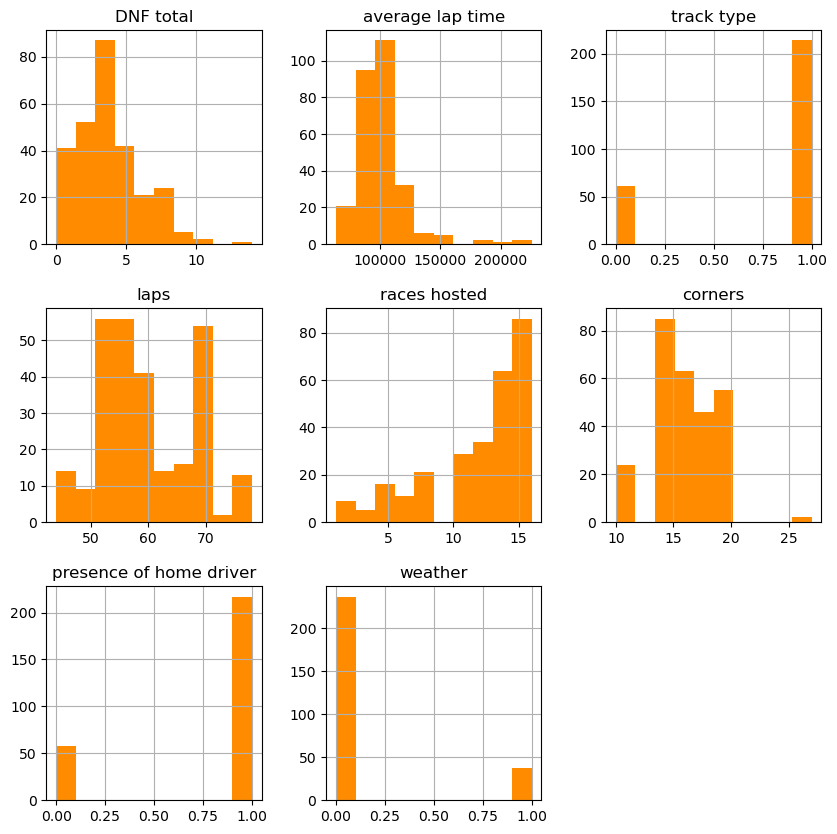

In [150]:
# I also want to plot my numerical explanatory variables
X1.hist(color='darkorange',figsize=(10,10))
plt.show()

Also to be expected, none of these variables have a normal distribution.

I also want to observe correlations between my variables. Because some of my variables are numerical whislt others are categorical (even though I've now encoded them into binary), I need to handle these separately.

In [80]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [81]:
# Using ANOVA (Analysis of Variance) test to assess relationships between my target + numerical explanatory variables
from scipy.stats import f_oneway
numericalVariables = ['DNF total', 'average lap time', 'laps', 'races hosted', 'corners']
numerical = raceData[numericalVariables]

In [82]:
# This section of code was written with assistance from ChatGPT
from scipy.stats import f_oneway
from tabulate import tabulate
results = []

for column in numerical.columns:
    f_stat, p_value = f_oneway(raceData[raceData['public opinion'] == 0][column], raceData[raceData['public opinion'] == 1][column])
    results.append([column, round(f_stat, 2), round(p_value, 2)])

headers = ["Column", "F-statistic", "P-value"]
formatted_results = tabulate(results, headers, tablefmt="pretty")
print(formatted_results)

+------------------+-------------+---------+
|      Column      | F-statistic | P-value |
+------------------+-------------+---------+
|    DNF total     |    15.52    |   0.0   |
| average lap time |    3.24     |  0.07   |
|       laps       |    0.44     |  0.51   |
|   races hosted   |    2.13     |  0.15   |
|     corners      |     2.5     |  0.11   |
+------------------+-------------+---------+


F-statistic = measure of difference in variance between the two groups (exciting & boring)
P-value = probability of observing such an F-statistic under the null hypothesis (that there's no difference between the groups)

Interpretation:

1. DNF total:
- Huge F-stat, indicating large difference between exciting + boring races
- Very low P-val, suggesting there's a significant difference between the two kinds of races
  
2. Average lap time:
- Smaller F-stat, indicating smaller difference in variable variance
- P-val is greater than typical significance level of 0.05 but only just
- Suggests there's some evidence that there's a difference between two kinds of races, but only just
  
3. Laps:
- Low F and high P sugggests there's no evidence to reject null hypothesis for laps
- Difference in variance isn't statistically significant
  
4. Races hosted
- Moderate F + P suggests that there's not strong evidence to reject null hypothesis
- Difference in variance isn't statistically significant
   
5. Corners
- Moderate F + P suggests that there's not strong evidence to reject null hypothesis
- Difference in variance isn't statistically significant


Now I want to see the relationship between my categorical variables and my target. For this, ANOVA is unsuitable so instead I shall use the chi-square test

In [83]:
categoricalVariables = ['track type', 'presence of home driver', 'weather']
categorical = raceData[categoricalVariables]

In [84]:
# Using Chi-squared test to assess relationships between my target + categorical explanatory variables
# This code was also written with help from ChatGPT
from scipy.stats import f_oneway, chi2_contingency
categorical_results = []

for column in categorical.columns:
    contingency_table = pd.crosstab(raceData['public opinion'], raceData[column])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    categorical_results.append([column, round(chi2, 2), round(p_value, 2)])

categorical_headers = ["Column", "Chi2", "P-value"]
categorical_formatted_results = tabulate(categorical_results, categorical_headers, tablefmt="pretty")

print("Categorical Results:")
print(categorical_formatted_results)

Categorical Results:
+-------------------------+-------+---------+
|         Column          | Chi2  | P-value |
+-------------------------+-------+---------+
|       track type        | 0.03  |  0.86   |
| presence of home driver | 0.62  |  0.43   |
|         weather         | 20.67 |   0.0   |
+-------------------------+-------+---------+


Interpretation:

1. Track type:
- Low Chi-sq and high P
- Suggests there isn't enough evidence to reject the null hypothesis
  
2. Presence of home driver:
- Moderate Chi-sq and P
- But still isn't enough evidence to reject the null hypothesis
  
3. Weather:
- High Chi-sq and very low P
- Suggests that there's a significant association between weather and race excitement
- Low P indicates that observed excitement across different weather conditions is unlikely to have occurred by chance
  

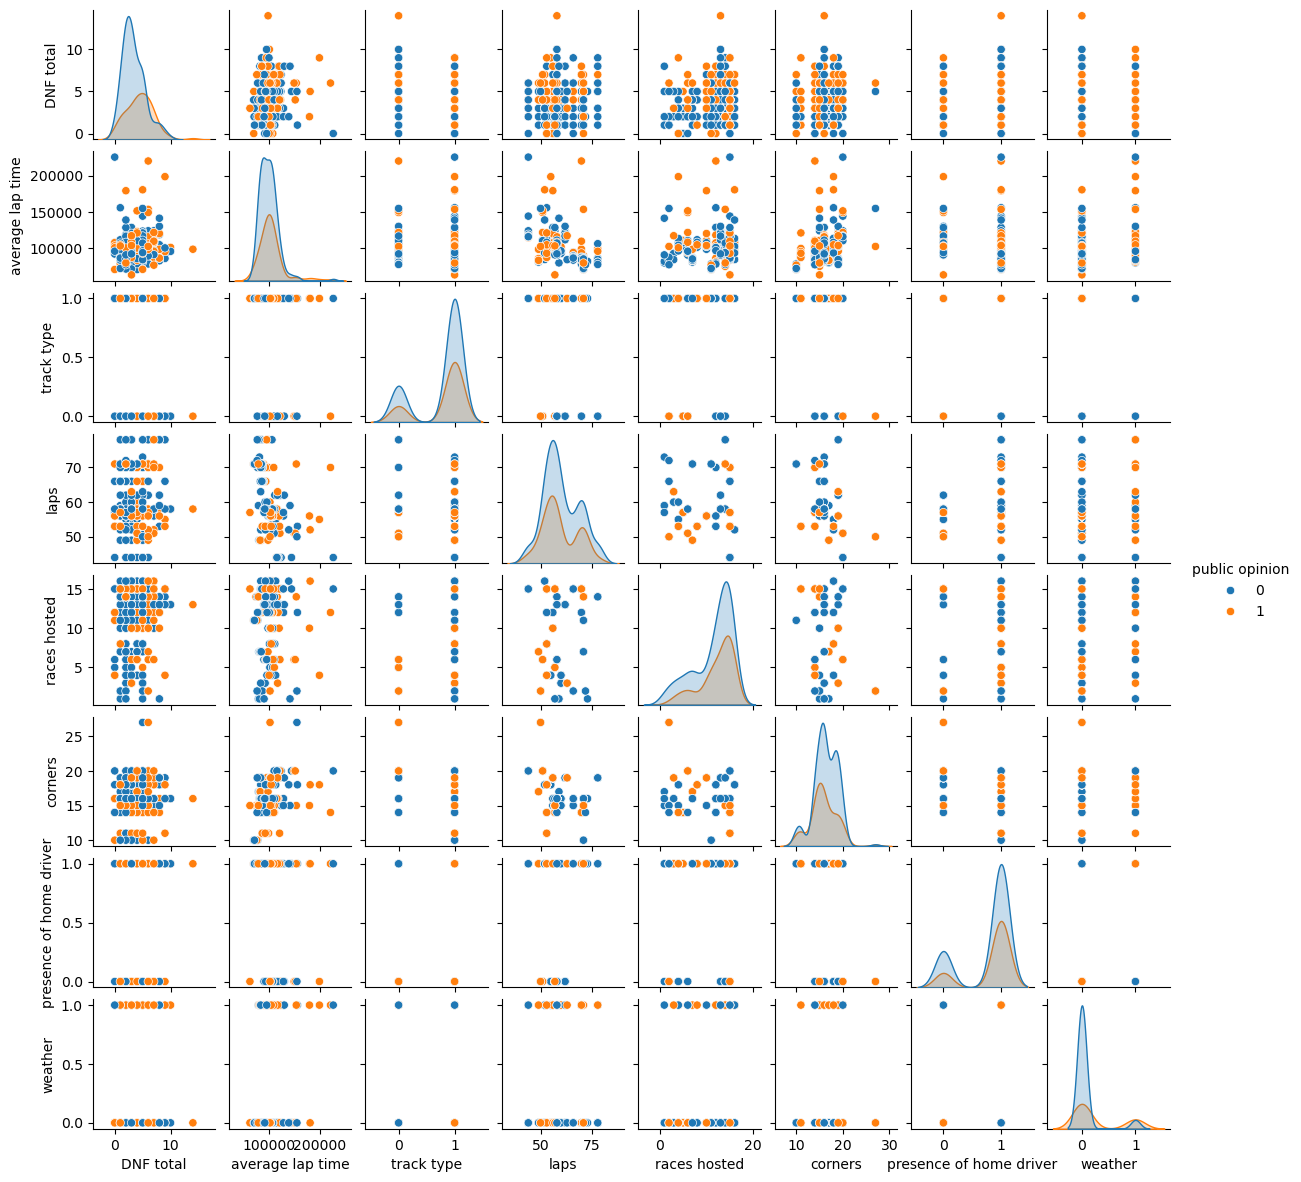

In [85]:
# Plotting these for fun
import seaborn as sns
sns.pairplot(raceData, hue='public opinion', height=1.5);

From this, I can infer that the number of DNFs, the weather (Rain/no rain) and average lap times have an impact on race excitement, whilst the impact of other variables included in this study do not display statistically significant results. This suggests that when building my model, it may be advantageous to exclude these other factors and only focus on the ones that display significance. However, I will first construct models that use all variables, employ feature importance and then adjust the models accordingly.

<span style="font-size: 22px; color: orange;">3. Machine Learning models</span>

In this project, I am interested in employing supervised machine learning techniques, specifically classification models. The aim of these are to predict categorical class labels of new cases based on past observations. The two models I shall trial in this study include:

1. Decision Trees
- This splits my dataset based on the most important attribute at each node
2. Random Forest
- This builds multiple decision trees and merges their predictions together to improve overall accuracy and deal with the issue of overfitting


**Decision Tree (DT)**

This model is able to predict the value (in this case, category) of a target variable by learning decision rules inferred from data features. The model passes each observation that goes through it via multiple branches of decisions that help it derive a final outcome for the given observation.

NOTE: due to the nature of tree-based algorithms, no feature standard scaling is required as DTs are not sensitive to variance between variables.

In [151]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [152]:
# Splitting the dataset into training and test sets
# Using a split of 66:33
(X1_train, X1_test, y1_train, y1_test) = train_test_split(X1, Y1, train_size=0.66, random_state=1)

Because the depth of a DT is a key parameter (determines the complexity of decision-making by the model), different max depths will be trialed in training the DT. The first model I shall run however shall involve no hyperparameter tuning

The out of sample test accuracy is : 0.564


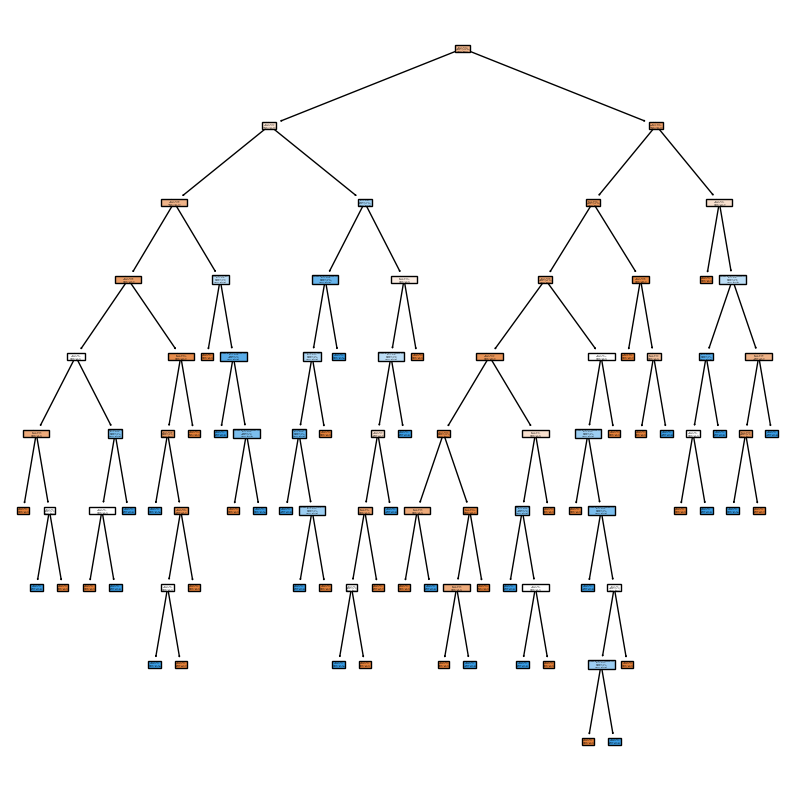

In [153]:
# Base DT model 1 (no hyperparameter tuning)
tree = DecisionTreeClassifier()
tree.fit(X1_train, y1_train)
y1_pred = tree.predict(X1_test)
print ('The out of sample test accuracy is : '+ str(round(accuracy_score(y1_test, y1_pred),3)))

# Plotting the DT
plt.figure(figsize=(10,10))
plot_tree(tree, filled=True, class_names=list(["Boring", "Exciting"]), feature_names=X1cols)
plt.show()

In [154]:
# I want to assess the performance of my DT model before hyperparameter tuning so I know what I'm working with
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y1_test, y1_pred)
precision = precision_score(y1_test, y1_pred)
recall = recall_score(y1_test, y1_pred)
f1 = f1_score(y1_test, y1_pred)

print('Accuracy: ' + str(round(accuracy, 3)))
print('Precision: ' + str(round(precision, 3)))
print('Recall: ' + str(round(recall, 3)))
print('F1 Score: ' + str(round(f1, 3)))

Accuracy: 0.564
Precision: 0.522
Recall: 0.286
F1 Score: 0.369


Explaining these metrics of performance:
1. Accuracy - the proportion of correctly classified instances out of the total number of instances
2. Precision - the proportion of true positives out of the total predicted positives
3. Recall - the proportion of true positives out of the total actual positives
4. F1 Score - the harmonised mean of precision and recall (balance between the two)

This tree is 'unpruned'; unexplainable and challenging to understand. Therefore, next I want to optimise it using hyperparamter tuning. Hyperparameters are those which are not directly learnt within the estimators but instead need to be tuned.

The out of sample test accuracy is : 0.617


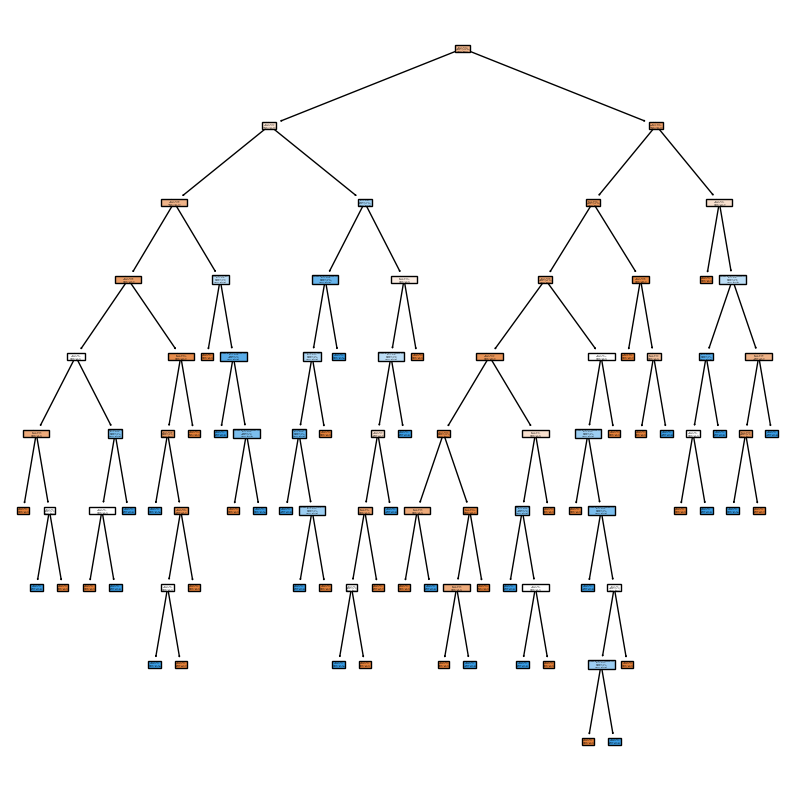

In [155]:
# DT model 1: Max depth = 3
tree1 = DecisionTreeClassifier(max_depth=3)
tree1.fit(X1_train, y1_train)
y1_pred = tree1.predict(X1_test)
print ('The out of sample test accuracy is : '+ str(round(accuracy_score(y1_test, y1_pred),3)))

# Plotting the DT
plt.figure(figsize=(10,10))
plot_tree(tree, filled=True, class_names=list(["Boring", "Exciting"]), feature_names=X1cols)
plt.show()

In [91]:
# Representing this in text
from dmba import textDecisionTree
print(textDecisionTree(tree1))

node=0 test node: go to node 1 if 5 <= 15.5 else to node 8
  node=1 test node: go to node 2 if 0 <= 3.5 else to node 5
    node=2 test node: go to node 3 if 1 <= 98255.86328125 else to node 4
      node=3 leaf node: [[0.812, 0.188]]
      node=4 leaf node: [[0.4, 0.6]]
    node=5 test node: go to node 6 if 5 <= 14.5 else to node 7
      node=6 leaf node: [[0.188, 0.812]]
      node=7 leaf node: [[0.538, 0.462]]
  node=8 test node: go to node 9 if 0 <= 5.5 else to node 12
    node=9 test node: go to node 10 if 3 <= 56.5 else to node 11
      node=10 leaf node: [[0.776, 0.224]]
      node=11 leaf node: [[0.95, 0.05]]
    node=12 test node: go to node 13 if 1 <= 95673.80859375 else to node 14
      node=13 leaf node: [[1.0, 0.0]]
      node=14 leaf node: [[0.4, 0.6]]


In [156]:
# Assessing model performance 
accuracy = accuracy_score(y1_test, y1_pred)
precision = precision_score(y1_test, y1_pred)
recall = recall_score(y1_test, y1_pred)
f1 = f1_score(y1_test, y1_pred)

print('Accuracy: ' + str(round(accuracy, 3)))
print('Precision: ' + str(round(precision, 3)))
print('Recall: ' + str(round(recall, 3)))
print('F1 Score: ' + str(round(f1, 3)))

Accuracy: 0.617
Precision: 0.6
Recall: 0.429
F1 Score: 0.5


The new model with hyperparameter tuning has an improved accuracy of 0.617, precision of 0.6, recall of 0.429 and F1 score of 0.5. Thus, hyperparameter tuning is improving my model.

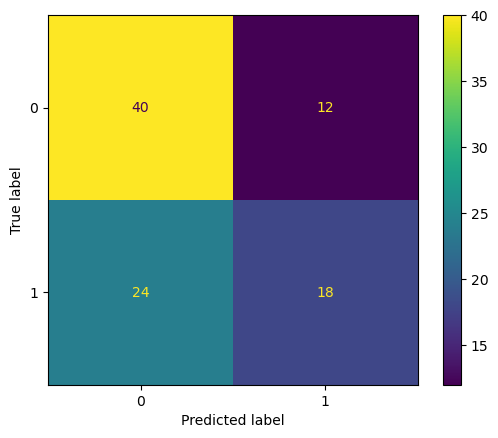

In [93]:
# Plotting a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(tree1, X1_test, y1_test)

In [94]:
# I want to see the imbalance  ratio of my dataset
# This code was written with help from ChatGPT
# Training set
minority_class_count_train = y1_train.value_counts().min()
majority_class_count_train = y1_train.value_counts().max()
imbalance_ratio_train = majority_class_count_train / minority_class_count_train
print('Imbalance Ratio (Training Set):', imbalance_ratio_train)

# Testing set
minority_class_count_test = y1_test.value_counts().min()
majority_class_count_test = y1_test.value_counts().max()
imbalance_ratio_test = majority_class_count_test / minority_class_count_test
print('Imbalance Ratio (Test Set):', imbalance_ratio_test)

Imbalance Ratio (Training Set): 2.4150943396226414
Imbalance Ratio (Test Set): 1.2380952380952381


This calculates the imbalance ratio for both the training and test sets. By looking at the imbalance of the training set, I can infer the class distribution used for model learning. Test set imbalance demonstrates whether or not there's a similar imbalance on unseen data. What these numbers show is that the model has an imbalanced sampling problem. To resolve this, I can train the classifer to either under or oversample the data. Before this however, I will play around with more hyperparameter tuning to see the effects of this

The out of sample test accuracy is : 0.553


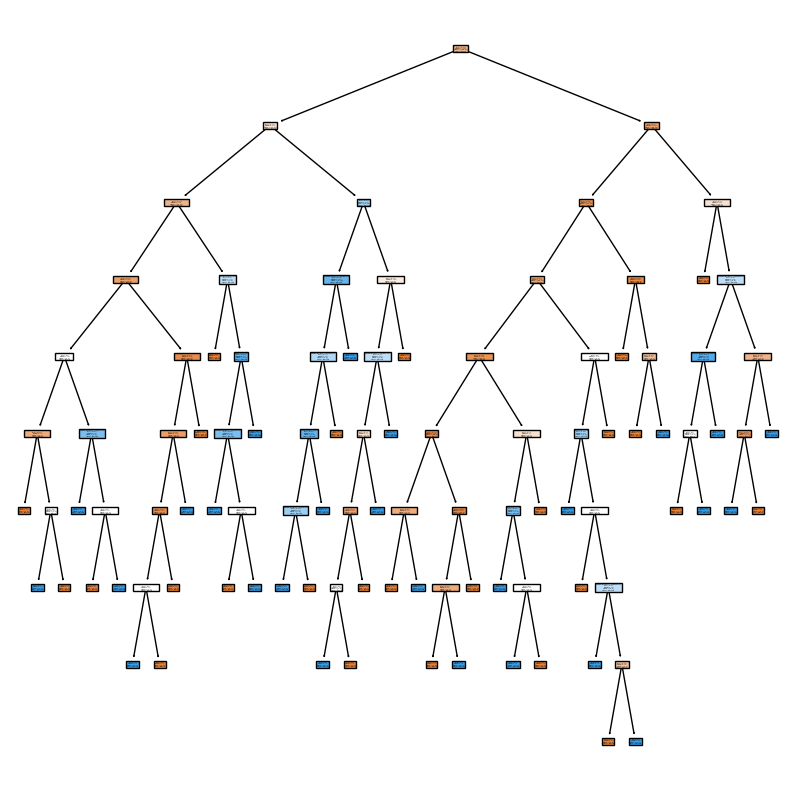

In [95]:
# DT model 2: Max leaf nodes = 10
tree2 = DecisionTreeClassifier(max_leaf_nodes=10)
tree2.fit(X1_train, y1_train)
y1_pred = tree2.predict(X1_test)
print ('The out of sample test accuracy is : '+ str(round(accuracy_score(y1_test, y1_pred),3)))

# Plotting the DT
plt.figure(figsize=(10,10))
plot_tree(tree, filled=True, class_names=list(["Boring", "Exciting"]), feature_names=X1cols)
plt.show()

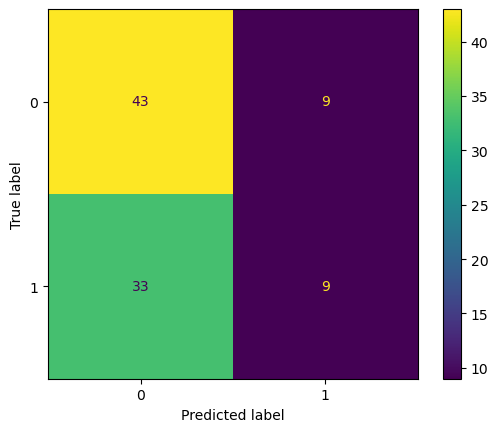

In [96]:
# Plotting a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(tree2, X1_test, y1_test)

No matter what value I change the max_leaf_nodes to, I return a lower accuracy score than when I was just changing the max_depth - thus I shall leave this parameter for now.

In [97]:
!pip install imblearn

The following code shall address the sample imbalance problem - I will trial oversampling my data

In [98]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority') 
X_over, y_over = oversample.fit_resample(X1_train, y1_train) 

the out of sample test accuracy is : 0.553


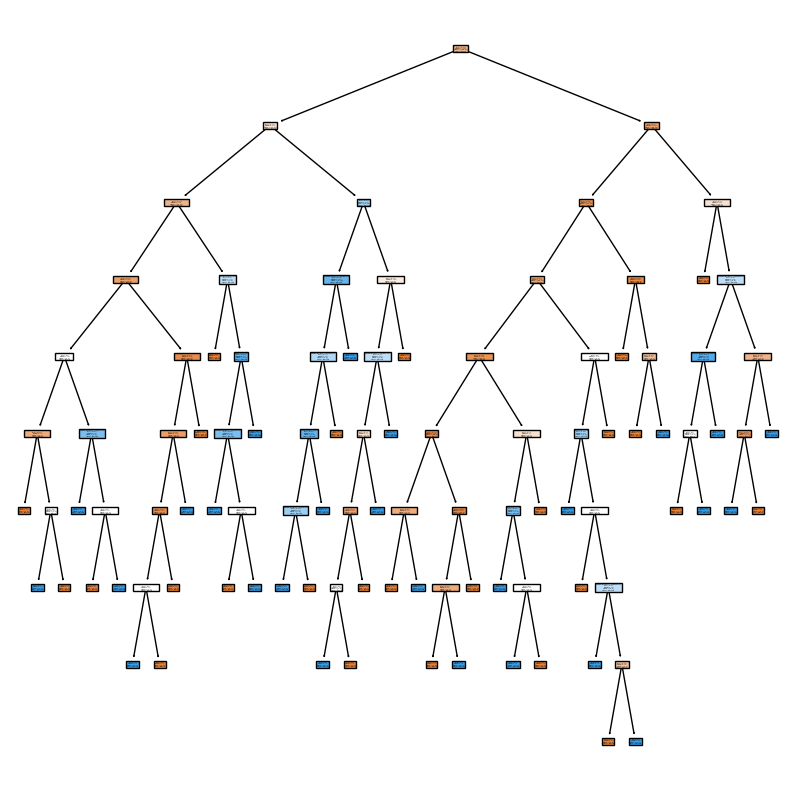

In [99]:
# DT model 3: Oversampled data with max depth = 3
tree3 = DecisionTreeClassifier(max_depth=3)
tree3.fit(X_over, y_over)
y1_pred3 = tree3.predict(X1_test)
print ('the out of sample test accuracy is : '+ str(round(accuracy_score(y1_test, y1_pred),3)))

# Plotting this
plt.figure(figsize=(10,10))
plot_tree(tree, filled=True, class_names=list(["Boring", "Exciting"]), feature_names=X1cols)
plt.show()

In [100]:
# Assessing model performance 
accuracy = accuracy_score(y1_test, y1_pred)
precision = precision_score(y1_test, y1_pred)
recall = recall_score(y1_test, y1_pred)
f1 = f1_score(y1_test, y1_pred)

print('Accuracy:', round(accuracy, 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Accuracy: 0.553
Precision: 0.5
Recall: 0.214
F1 Score: 0.3


In [101]:
# I want to see the imbalance  ratio of my dataset after oversampling
# This code was written with help from ChatGPT
class_distribution = y_over.value_counts()
print('Class Distribution after Oversampling:')
print(class_distribution)

minority_class_count_over = class_distribution.min()
majority_class_count_over = class_distribution.max()
imbalance_ratio_over = majority_class_count_over / minority_class_count_over
print('Imbalance Ratio after Oversampling:', imbalance_ratio_over)

Class Distribution after Oversampling:
public opinion
0                 128
1                 128
Name: count, dtype: int64
Imbalance Ratio after Oversampling: 1.0


Whilst the oversampled + max_depth = 3 DT deals with the issue of oversampling, the accuracy, precision, recall and F1 score is significantly better in the model that has an unequal class distribution. Therefore, I have decided to accept the issue of imbalance and use my hyperparameter tuned (max_depth = 3) model as my final one.

**Random Forest (RF)**

This is an ensemble learning method which uses multiple simple predictors to make a better prediction. The hypothesis that underpins it is that multiple learners will generate better results than a single learner. RFs use multiple DTs, the outcomes of which either point to an outcome that is most often predicted or a mean prediction across multiple trees

As before, I will first run a base model with no hyperparametric tuning.

In [157]:
# Base RF model 1 (no hyperparameter tuning)
from sklearn.ensemble import RandomForestClassifier
base_RF = RandomForestClassifier()
base_RF.fit(X1_train, y1_train)
y1_pred = base_RF.predict(X1_test)

# Assessing model performance
accuracy = accuracy_score(y1_test, y1_pred)
precision = precision_score(y1_test, y1_pred)
recall = recall_score(y1_test, y1_pred)
f1 = f1_score(y1_test, y1_pred)

print('Accuracy:', round(accuracy, 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Accuracy: 0.66
Precision: 0.857
Recall: 0.286
F1 Score: 0.429


The DT base model returned a lower accuracy score of 0.596 - this could suggest right off the bat that RF is a better model fit than DT. However, the low recall score suggests that the model isn't good at capturing a significant portion of 'exciting' races. Hyperparametric tuning will indicate if this is the case or not. 

Informing my understanding of hyperparametric tuning is Koehrsen, W.'s (2018) notebook 'Hyperparameter Tuning the Random Forest in Python', available on Medium. The following sections of code have been taken from this notebook. Credit must be attributed to him.

First stage of hyperparametric tuning will be the use of RandomisedSearchCV. This will allow me to 'define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values' (Koehrsen, 2018). 

In [158]:
# RANDOMISED SEARCH CV
# Partial credit for this block of code attributed to Koehrsen (2018), the rest was made using combination of ChatGPT and StackOverflow suggestions
# This code creates a parameter grid to sample from during fitting
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Defining hyperparameter options
# This is key - it sets the range of values that the RandomisedSearchCV can sample from during the search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# I need to store these options in a dictionary
# 'random_grid' is the dictionary  
# This dictionary serves as the 'param_distributions' in the RandomisedSearchCV
# IE. the searchCV will use this dictionary to sample hyperparameter combinations 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Now I will perform a randomised search over the hyperparameter space for a RF model
# Creating the object + dealing with the 2d array issue in _flattened
# Create a base model
random_RF = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = random_RF, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
y1_train_flattened = np.ravel(y1_train)

# This performs the actual random search
# 'fit' trains + evaluates models with different hyperparameter combinations based on specified search space
random_search.fit(X1_train, y1_train_flattened)

# Print the best parameters
# print("Best Hyperparameters:", random_search.best_params_)

# This uses the best estimator obtained from the random search to make predictions on the test set
# Aka, the model uses the optimal hyperparameters found during the random search
y_pred_randomTest = random_search.best_estimator_.predict(X1_test)

accuracy = accuracy_score(y1_test, y_pred_randomTest)
precision = precision_score(y1_test,  y_pred_randomTest)
recall = recall_score(y1_test,  y_pred_randomTest)
f1 = f1_score(y1_test,  y_pred_randomTest)

print("Accuracy (RandomCV):", round(accuracy, 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy (RandomCV): 0.596
Precision: 0.7
Recall: 0.167
F1 Score: 0.269
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   2.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   4.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, 

While a RandomisedSearchCV has several perks, I can now perform a GridSearchCV after this. The reason being that whilst RSCV explores a broad range of hyperparameter combinations, it might miss out on fine-tuning specific values. GSCV allows to focus on a narrower, more specific range around values identified as promising during the RSCV. It is more exhaustive and can help find the optimal hyperparameter values. Moreover, it can also be seen as a confirmation/validation step. All in all, using both aims to strike a balance between efficiency and thoroughness in hyperparameter tuning. 

In [104]:
# GRID SEARCH CV
# Code to use GridSearchCV - credit attributed to both Koehrsen (2018) and Sruthi (2023) via Analytics Vidhya with additional cleaning by ChatGPT
from sklearn.model_selection import GridSearchCV

# I want to create the parameter grid based on the results of my random search
param_grid = {
    'n_estimators':[1600],
    'min_samples_split':[2],
    'min_samples_leaf':[4],
    'max_features':['sqrt'],
    'max_depth':[10],
    'bootstrap':[True]
}

# Create a base model
grid_RF = RandomForestClassifier()

# Then I Instantiate GridSearchCV - I use RF, the base model I made before
grid_search = GridSearchCV(estimator=grid_RF, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
y1_train_flattened = np.ravel(y1_train)

# Fit the model to the training data
grid_search.fit(X1_train, y1_train_flattened)

# Print the best parameters
# print("Best Hyperparameters:", grid_search.best_params_)

# I will use the test set to see how the grid model performs on new unseen data
y_pred_gridTest = grid_search.best_estimator_.predict(X1_test)

accuracy = accuracy_score(y1_test, y_pred_gridTest)
precision = precision_score(y1_test,  y_pred_gridTest)
recall = recall_score(y1_test,  y_pred_gridTest)
f1 = f1_score(y1_test,  y_pred_gridTest)

print("Accuracy (GridCV):", round(accuracy, 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Accuracy (GridCV): 0.596
Precision: 0.7
Recall: 0.167
F1 Score: 0.269


**Feature importance**

Now that I've run several models, I want to think about feature imporance. I will plot this for the models which have performed the best (DT model 2 + RF random model). The code for this was taken from the GEOG0115 practical 6 notebook.

In [106]:
# Defining the function to plot feature importance
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],color='darkorange')
    plt.title(model_type + 'feature importance')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')

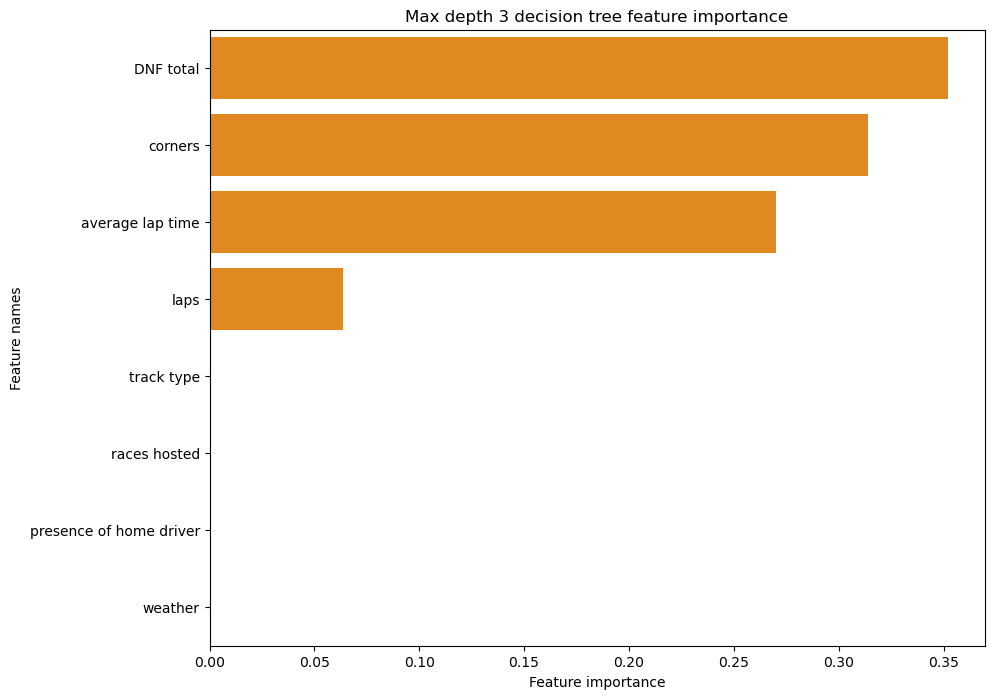

In [107]:
# Plotting the max_depth = 3 DT model (tree1)
plot_feature_importance(tree1.feature_importances_, X1_train.columns, 'Max depth 3 decision tree ')

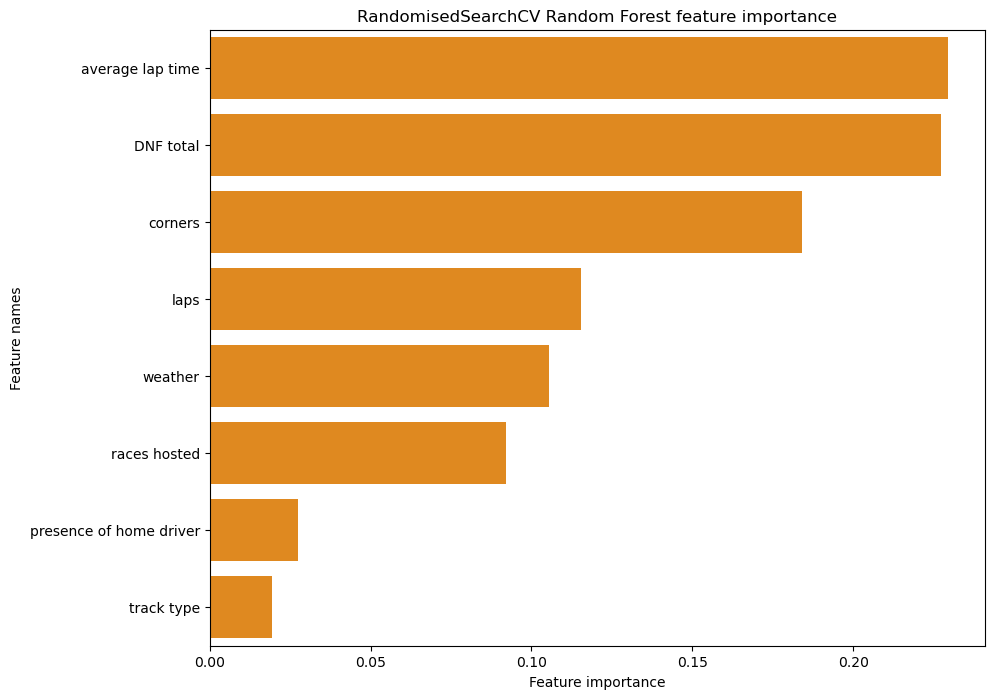

In [108]:
# Plotting the RF random model
plot_feature_importance(random_search.best_estimator_.feature_importances_, X1_train.columns, 'RandomisedSearchCV Random Forest ')

Both of these plots show me that average lap time, DNF total, corners and laps are the key features in my models. As a result, I'm going to re-run my models but including only these features to see what the effect is. The idea is that this could help improve interpretation of my results and also may reduce overfitting. 

**Re-running models with hyperparameter tuning and the inclusion of important features**

The out-of-sample test accuracy with selected features is: 0.617


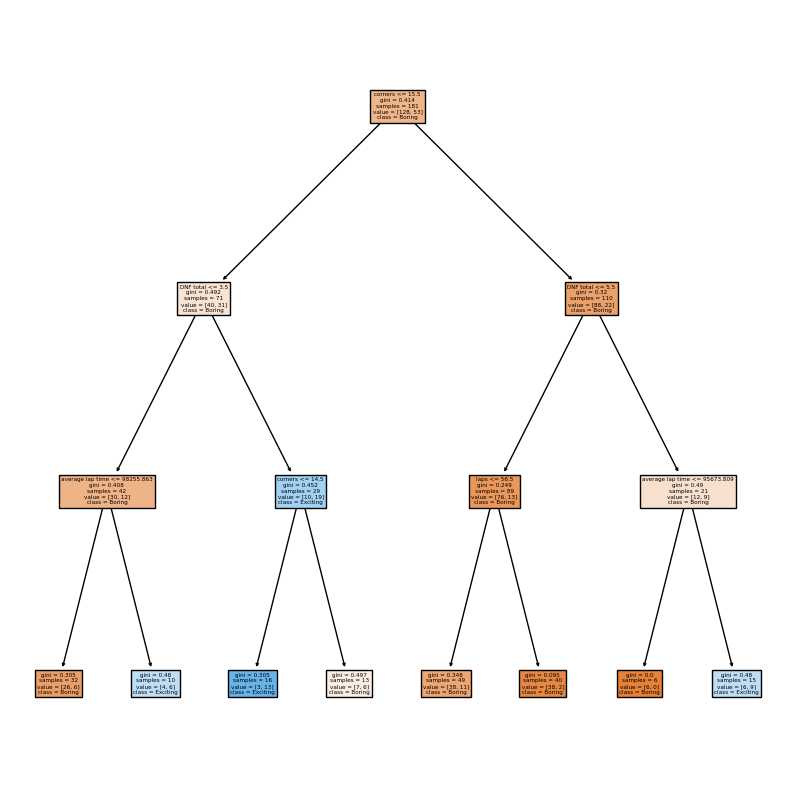

Accuracy: 0.617
Precision: 0.6
Recall: 0.429
F1 Score: 0.5


In [109]:
# Re-runnning the DT (max depth = 3)
# This code was edited with help from ChatGPT
# Subsetting my variables to only have the ones picked out from the feature importance plot & creating new dataset to store this
featured = ['DNF total', 'average lap time', 'laps', 'corners']  
X1_train_featured = X1_train[featured]
X1_test_featured = X1_test[featured]

# Training the DT on the new dataset
tree1Featured = DecisionTreeClassifier(max_depth=3)
tree1Featured.fit(X1_train_featured, y1_train)

# Evaluating model performance on the test set
y1_pred_featured = tree1Featured.predict(X1_test_featured)
print('The out-of-sample test accuracy with selected features is:', round(accuracy_score(y1_test, y1_pred_featured), 3))

# Plotting 
plt.figure(figsize=(10, 10))
plot_tree(tree1Featured, filled=True, class_names=list(["Boring", "Exciting"]), feature_names=featured)
plt.show()

# Assessing model performance 
accuracy = accuracy_score(y1_test, y1_pred_featured)
precision = precision_score(y1_test,  y1_pred_featured)
recall = recall_score(y1_test,  y1_pred_featured)
f1 = f1_score(y1_test,  y1_pred_featured)

print("Accuracy:", round(accuracy, 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

In [110]:
# Re-runnning the RF (RandomisedSearchCV)
random_RF_featured = RandomForestClassifier()
random_search_featured = RandomizedSearchCV(estimator=random_RF_featured, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
y1_train_flattened = np.ravel(y1_train)

# Performing the random search on selected features
random_search_featured.fit(X1_train_featured, y1_train_flattened)

# Using best estimator to make predictions on test set
y_pred_randomTest_featured = random_search_featured.best_estimator_.predict(X1_test_featured)

# Assessing model performance 
accuracy = accuracy_score(y1_test, y_pred_randomTest_featured)
precision = precision_score(y1_test,  y_pred_randomTest_featured)
recall = recall_score(y1_test,  y_pred_randomTest_featured)
f1 = f1_score(y1_test,  y_pred_randomTest_featured)

print("Accuracy:", round(accuracy, 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   7.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   5.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators

KeyboardInterrupt: 

Re-running with selected features had no impact on model performance for either DT or RF. Therefore, this shall not be explored further.

**Cross validating my models**

Now I want to perform cross validation to ensure that my model performs consistently across various subsets of my data. I will do this for my final two selected models. The code for this was creating using a combination of StackOverflow posts and ChatGPT to neaten it up.

In [111]:
# Cross-validating tree2 (DT with max_depth = 3)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
tree1 = DecisionTreeClassifier(max_depth=3)

# Cross-validating my model using 'StratifiedKFold' - this ensures that each fold maintains the same distribution of the target variable
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(tree1, X1_train, y1_train, scoring='accuracy', cv=cv)

print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

# Fitting the model on the entire training set
tree1.fit(X1_train, y1_train)

# Making predictions on the test set
y1_pred = tree1.predict(X1_test)

Cross-Validation Scores: [0.75675676 0.66666667 0.69444444 0.75       0.66666667]
Mean Accuracy: 0.7069069069069068
Standard Deviation: 0.039334181171585


In [112]:
# Cross-validating random_RF (randomisedsearchCV RF)
random_RF = RandomForestClassifier()

# Setting up the cross-validation and performing with best estimator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=random_RF, param_distributions=random_grid, n_iter=100, cv=cv, verbose=2, random_state=42, n_jobs=-1)
y1_train_flattened = np.ravel(y1_train)
random_search.fit(X1_train, y1_train_flattened)
cv_scores = cross_val_score(random_search.best_estimator_, X1_train, y1_train_flattened, scoring='accuracy', cv=cv)

print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

# Make predictions on the test set (use best estimator)
y_pred_random_test = random_search.best_estimator_.predict(X1_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Cross-Validation Scores: [0.67567568 0.69444444 0.75       0.69444444 0.69444444]
Mean Accuracy: 0.7018018018018019
Standard Deviation: 0.025171543050685745


Based on the results from cross validation, I can see that the RF model performs slightly better than the DT. This is because it has a higher mean accuracy and lower standard deviation (meaning more consistent performance across different folds). Therefore, I will select the RF model to focus on for the rest of my study.

**Training the final model**

Now that I've narrowed my model selection down to one, I want to evaluate it on a separate test set.

Accuracy on Test Set: 0.6063829787234043
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.94      0.73        52
           1       0.73      0.19      0.30        42

    accuracy                           0.61        94
   macro avg       0.66      0.57      0.51        94
weighted avg       0.65      0.61      0.54        94



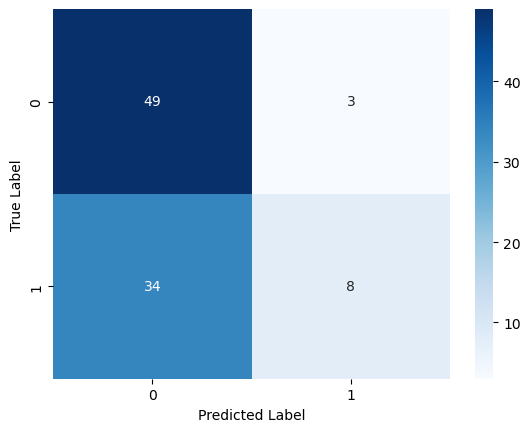

In [113]:
# FINAL TRAINING
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Variable storing the best hyperparameters as determined by the RandomizedSearchCV
best_hyperparameters = {
    'n_estimators': 1600,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 10,
    'bootstrap': True
}

# Training the final Random Forest model
final_rf_model = RandomForestClassifier(**best_hyperparameters)
final_rf_model.fit(X1_train, y1_train)

# Making predictions on the test set
y_pred_test = final_rf_model.predict(X1_test)

# Evaluating model performance on the test set
accuracy = accuracy_score(y1_test, y_pred_test)
report = classification_report(y1_test, y_pred_test)
cm = confusion_matrix(y1_test, y_pred_test)

print(f"Accuracy on Test Set: {accuracy}")
print("Classification Report:\n", report)

# Visualise using confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

It looks as though there might be some issues with class imbalance (identified earlier during DT modelling but not addressed with the RF model). To see if this is the case, I will try resampling my dataset using SMOTE which oversamples my data and RandomUnderSampler which undersamples my data. The code for this came from a combination of StackExchange tips, Chat GPT and Kaggle notebooks. 

Accuracy on Test Set: 0.5957446808510638
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.69      0.65        52
           1       0.56      0.48      0.51        42

    accuracy                           0.60        94
   macro avg       0.59      0.58      0.58        94
weighted avg       0.59      0.60      0.59        94



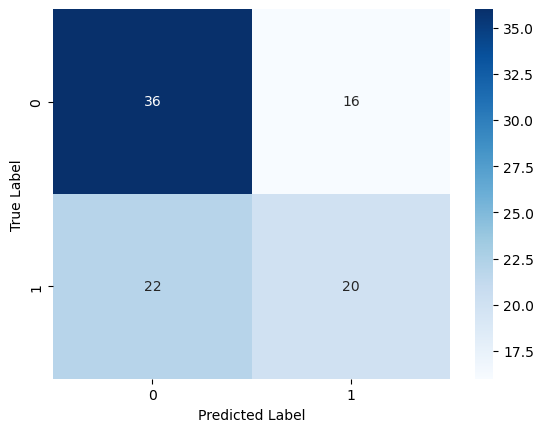

In [114]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Creating instances of SMOTE and RandomUnderSampler and then sorting the ratio of sample numbers in the minority class (Exciting) over majority class (boring) post resampling
over_sampler = SMOTE(sampling_strategy=0.5)
under_sampler = RandomUnderSampler(sampling_strategy=0.8)
model = RandomForestClassifier(**best_hyperparameters)

# This combines the oversampling, undersampling and model using Pipeline class
# As iterated by ChatGPT, 'Each step in the pipeline is defined as a tuple where the first element is a string identifier, and the second element is the corresponding operation or model'
imbalanced_pipeline = Pipeline([
    ('over', over_sampler),
    ('under', under_sampler),
    ('model', model)
])

# Training the model
imbalanced_pipeline.fit(X1_train, y1_train)

# Making predictions on test set
y_pred = imbalanced_pipeline.predict(X1_test)

# Evaluating model performance on test set
accuracy = accuracy_score(y1_test, y_pred)
report = classification_report(y1_test, y_pred)
cm = confusion_matrix(y1_test, y_pred)

# Assessing accuracy
print(f"Accuracy on Test Set: {accuracy}")
print("Classification Report:\n", report)

# Visualising using a correlation matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

With resampling, recall for 'exciting' races has improved a lot, meaning the model is now better at identifying instances of these races. Precision has slightly decreased (meaning potential for more false positives) but not enormous. F1 score also imrpvoed which means there's a better precision-recall balance. As a result, resampling has been good for the model as exciting races are better identified without a huge effect on overall accuracy. The trade off (false positives) isn't such an issue in this case.

The final step is now to perform a final evaluation of the model on my original dataset. This allows me to assess how well the model generalises to the whole dataset - this will include data points that weren't used in training/tuning/testing.

Accuracy on original dataset: 0.818
Classification report on original dataset:
               precision    recall  f1-score   support

           0       0.81      0.95      0.87       180
           1       0.86      0.57      0.68        95

    accuracy                           0.82       275
   macro avg       0.83      0.76      0.78       275
weighted avg       0.82      0.82      0.81       275



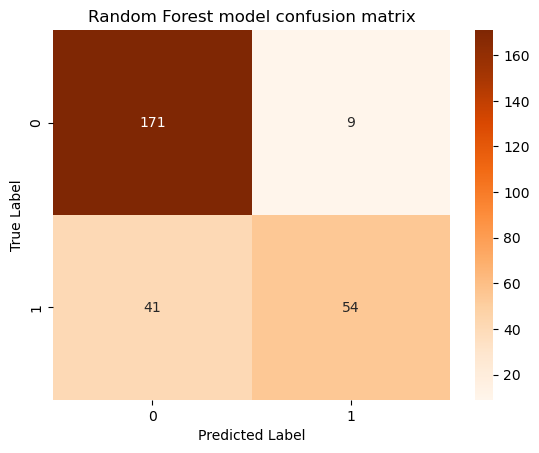

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train the final model
final_model = RandomForestClassifier(**best_hyperparameters)
final_model.fit(X1, Y1)

# Predictions on the original dataset
y_pred_original = final_model.predict(X1)

# Evaluating performance
accuracy_original = accuracy_score(Y1, y_pred_original)
report_original = classification_report(Y1, y_pred_original)
cm_original = confusion_matrix(Y1, y_pred_original)

print(f"Accuracy on original dataset: {accuracy_original:.3f}")
print("Classification report on original dataset:\n", report_original)

# Plotting correlation matrix
sns.heatmap(cm_original, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
heatmap.set_xticklabels(['Boring', 'Exciting'])
heatmap.set_xlabel("Predicted Label")
heatmap.set_yticklabels(['Boring', 'Exciting'])
heatmap.set_ylabel("True Label")
plt.title('Random Forest model confusion matrix')
plt.show()

The results from the final evaluation on the origianl dataset illustrate how the model generalises to unseen instances. It has an accuracy of 0.82 (82%) - meaning it performs well on the whole dataset. It has an equal precision for both classes too. The recall for 'exciting' races is its only downfall but it's a great improvement on past model attempts. This is therefore my final model. 

I will now run the feature importance function from earlier to assess the relative influence of my various factors used in my final model - it will be useful to see if these differ from the feature importance plot before. 

In [116]:
# Same function as before
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],color='darkorange')
    plt.title(model_type + 'feature importance')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')

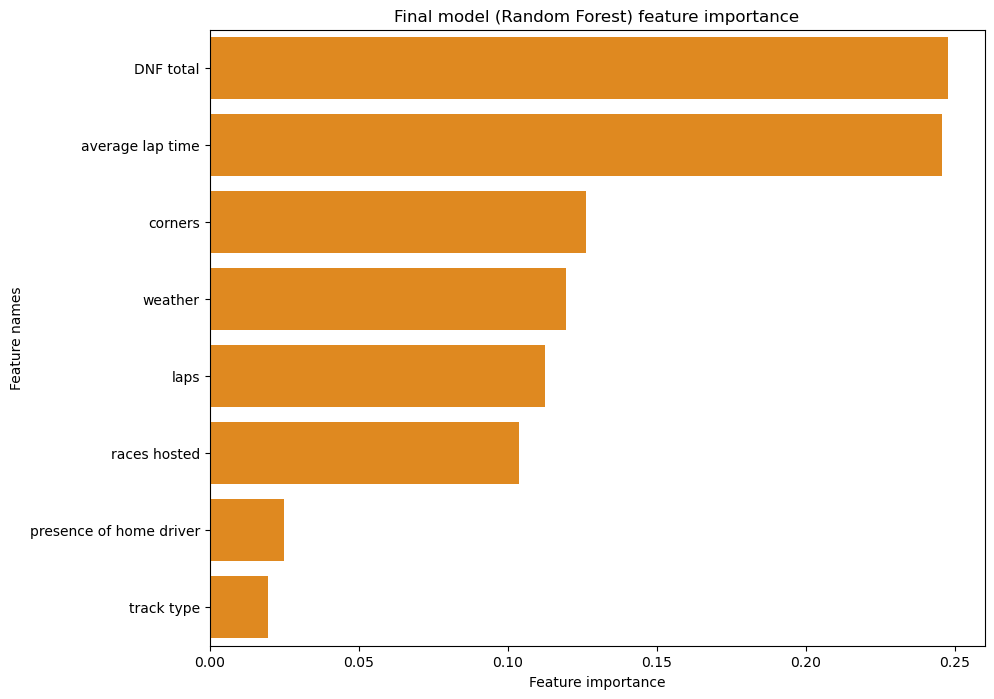

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   6.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   5.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   1.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   1.9s
[CV] END bootstrap=False, max_depth=100,

In [117]:
# Plotting feature importance of final model
plot_feature_importance(final_model.feature_importances_, X1_train.columns, 'Final model (Random Forest) ')

The final feature importance assessment does vary ever so slightly from the original RF plot but not enormously. The gap between the importance between average lap time and DNF total has shrunk, suggesting they are more equally important as the top variables. The importance of corners has reduced substantially as has the role of laps. Weather has increased in importance in the meantim. These results were closer to what was expected based on theory + common sense so this is reassuring. 